# Analysis of COVID-19 County Data from The New York Times

*Author: Mark Bauer*  
*Date: April 11, 2020*

The New York Times Github Data [Repository](https://github.com/nytimes/covid-19-data).   
The New York Time [News Article](https://www.nytimes.com/article/coronavirus-county-data-us.html).  
The New York Times COVID-19 US Map: https://www.nytimes.com/interactive/2020/us/coronavirus-us-cases.html.   
The New York Times COVID-19 Global Map: https://www.nytimes.com/interactive/2020/world/coronavirus-maps.html.

In [1]:
# importing libraries
import pandas as pd # the pd is by convention
import numpy as np # as is the np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import FuncFormatter
from matplotlib.dates import DateFormatter
import matplotlib.dates as dates
import seaborn as sns
import geopandas as gpd
import zipfile
from zipfile import ZipFile
from io import BytesIO
import os
import zipfile
from zipfile import ZipFile
from os.path import basename
import requests
import urllib
import squarify  

# to Plot matplotlib figures inline on the notebook
%matplotlib inline
sns.set(color_codes=True)

In [2]:
#Printing verions of Python modules and packages with **watermark** - the IPython magic extension.

%reload_ext watermark
%watermark -v -p numpy,pandas,matplotlib,matplotlib.pyplot,seaborn

CPython 3.7.1
IPython 7.2.0

numpy 1.16.1
pandas 1.0.0
matplotlib 3.0.2
matplotlib.pyplot 3.0.2
seaborn 0.9.0


In [3]:
url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv'

covid_19_counties_data = pd.read_csv(url)

In [4]:
covid_19_counties_data.head(10)

date       county       state     fips  cases  deaths
0  2020-01-21    Snohomish  Washington  53061.0      1       0
1  2020-01-22    Snohomish  Washington  53061.0      1       0
2  2020-01-23    Snohomish  Washington  53061.0      1       0
3  2020-01-24         Cook    Illinois  17031.0      1       0
4  2020-01-24    Snohomish  Washington  53061.0      1       0
5  2020-01-25       Orange  California   6059.0      1       0
6  2020-01-25         Cook    Illinois  17031.0      1       0
7  2020-01-25    Snohomish  Washington  53061.0      1       0
8  2020-01-26     Maricopa     Arizona   4013.0      1       0
9  2020-01-26  Los Angeles  California   6037.0      1       0

In [5]:
table = covid_19_counties_data.sort_values(by=['date', 'cases'], 
                                ascending=[False, False]).drop_duplicates(subset ="county", 
                                keep = 'first').reset_index(drop=True).head(10)

table['cases'] = table['cases'].map('{:,}'.format)
table['deaths'] = table['deaths'].map('{:,}'.format)
table.drop('fips', axis=1, inplace=True)
                 
print(table.to_markdown())

|    | date       | county        | state      | cases   | deaths   |
|---:|:-----------|:--------------|:-----------|:--------|:---------|
|  0 | 2020-04-27 | New York City | New York   | 160,499 | 11,857   |
|  1 | 2020-04-27 | Nassau        | New York   | 34,865  | 2,003    |
|  2 | 2020-04-27 | Suffolk       | New York   | 32,470  | 1,147    |
|  3 | 2020-04-27 | Cook          | Illinois   | 31,953  | 1,347    |
|  4 | 2020-04-27 | Westchester   | New York   | 28,007  | 1,077    |
|  5 | 2020-04-27 | Los Angeles   | California | 20,417  | 942      |
|  6 | 2020-04-27 | Wayne         | Michigan   | 15,872  | 1,622    |
|  7 | 2020-04-27 | Bergen        | New Jersey | 15,104  | 960      |
|  8 | 2020-04-27 | Hudson        | New Jersey | 13,925  | 673      |
|  9 | 2020-04-27 | Essex         | New Jersey | 13,047  | 1,028    |


In [6]:
covid_19_counties_data.shape

(95420, 6)

In [7]:
print('New York Times COVID-19 data as of', covid_19_counties_data.sort_values(by='date', 
                                   ascending=False)['date'].iloc[0])

New York Times COVID-19 data as of 2020-04-27


In [8]:
current_date = covid_19_counties_data.sort_values(by='date', ascending=False)['date'].iloc[0]

In [9]:
print('The current date of this notebook is', current_date)

The current date of this notebook is 2020-04-27


In [10]:
covid_19_counties_data.date = pd.to_datetime(covid_19_counties_data.date, infer_datetime_format=True)

In [11]:
covid_19_counties_data.dtypes

date      datetime64[ns]
county            object
state             object
fips             float64
cases              int64
deaths             int64
dtype: object

In [12]:
print(covid_19_counties_data['county'])

0         Snohomish
1         Snohomish
2         Snohomish
3              Cook
4         Snohomish
            ...    
95415      Sublette
95416    Sweetwater
95417         Teton
95418         Uinta
95419      Washakie
Name: county, Length: 95420, dtype: object


In [13]:
covid_19_counties_data['county_name'] = (covid_19_counties_data['county'] + ", " + covid_19_counties_data['state'])

In [14]:
covid_19_counties_data

date      county       state     fips  cases  deaths  \
0     2020-01-21   Snohomish  Washington  53061.0      1       0   
1     2020-01-22   Snohomish  Washington  53061.0      1       0   
2     2020-01-23   Snohomish  Washington  53061.0      1       0   
3     2020-01-24        Cook    Illinois  17031.0      1       0   
4     2020-01-24   Snohomish  Washington  53061.0      1       0   
...          ...         ...         ...      ...    ...     ...   
95415 2020-04-27    Sublette     Wyoming  56035.0      1       0   
95416 2020-04-27  Sweetwater     Wyoming  56037.0     10       0   
95417 2020-04-27       Teton     Wyoming  56039.0     64       1   
95418 2020-04-27       Uinta     Wyoming  56041.0      6       0   
95419 2020-04-27    Washakie     Wyoming  56043.0      4       0   

                 county_name  
0      Snohomish, Washington  
1      Snohomish, Washington  
2      Snohomish, Washington  
3             Cook, Illinois  
4      Snohomish, Washington  
...                      ...  
95415      Sublette, Wyoming  
95416    Sweetwater, Wyoming  
95417         Teton, Wyoming  
95418         Uinta, Wyoming  
95419      Washakie, Wyoming  

[95420 rows x 7 columns]

In [15]:
covid_19_counties_data.loc[covid_19_counties_data.county == 'Unknown']

date   county           state  fips  cases  deaths  \
418   2020-03-01  Unknown    Rhode Island   NaN      2       0   
450   2020-03-02  Unknown    Rhode Island   NaN      2       0   
485   2020-03-03  Unknown    Rhode Island   NaN      2       0   
522   2020-03-04  Unknown    Rhode Island   NaN      2       0   
569   2020-03-05  Unknown    Rhode Island   NaN      2       0   
...          ...      ...             ...   ...    ...     ...   
94680 2020-04-27  Unknown     Puerto Rico   NaN   1388      53   
94685 2020-04-27  Unknown    Rhode Island   NaN   1378     118   
95095 2020-04-27  Unknown            Utah   NaN      0       2   
95111 2020-04-27  Unknown         Vermont   NaN      3       0   
95115 2020-04-27  Unknown  Virgin Islands   NaN     59       4   

                   county_name  
418      Unknown, Rhode Island  
450      Unknown, Rhode Island  
485      Unknown, Rhode Island  
522      Unknown, Rhode Island  
569      Unknown, Rhode Island  
...                        ...  
94680     Unknown, Puerto Rico  
94685    Unknown, Rhode Island  
95095            Unknown, Utah  
95111         Unknown, Vermont  
95115  Unknown, Virgin Islands  

[1053 rows x 7 columns]

In [16]:
print(len(covid_19_counties_data.loc[covid_19_counties_data.county == 'Unknown']))

1053


In [17]:
covid_19_counties_data = covid_19_counties_data.loc[covid_19_counties_data.county != 'Unknown']

In [18]:
covid_19_counties_data.loc[covid_19_counties_data.county == 'Unknown']

Empty DataFrame
Columns: [date, county, state, fips, cases, deaths, county_name]
Index: []

# Begin Analysis

In [19]:
covid_19_counties_data.dtypes

date           datetime64[ns]
county                 object
state                  object
fips                  float64
cases                   int64
deaths                  int64
county_name            object
dtype: object

In [20]:
epi_curve = covid_19_counties_data.sort_values(by='date')

In [21]:
epi_curve = epi_curve.groupby(by='date')['cases'].sum().reset_index()

In [22]:
epi_curve['NewDate'] = epi_curve.date.dt.strftime("%m-%d")

In [23]:
epi_curve

date   cases NewDate
0  2020-01-21       1   01-21
1  2020-01-22       1   01-22
2  2020-01-23       1   01-23
3  2020-01-24       2   01-24
4  2020-01-25       3   01-25
..        ...     ...     ...
93 2020-04-23  859915   04-23
94 2020-04-24  897163   04-24
95 2020-04-25  930907   04-25
96 2020-04-26  957125   04-26
97 2020-04-27  979266   04-27

[98 rows x 3 columns]

In [24]:
epi_curve['daily_cases'] = epi_curve['cases'].diff()

In [25]:
epi_curve.head()

date  cases NewDate  daily_cases
0 2020-01-21      1   01-21          NaN
1 2020-01-22      1   01-22          0.0
2 2020-01-23      1   01-23          0.0
3 2020-01-24      2   01-24          1.0
4 2020-01-25      3   01-25          1.0

In [26]:
epi_curve['daily_cases'].loc[epi_curve.daily_cases.isnull()]

0   NaN
Name: daily_cases, dtype: float64

In [27]:
epi_curve['daily_cases'].loc[epi_curve.daily_cases.isnull()] = epi_curve.cases

/Users/geribauer/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [28]:
epi_curve['daily_cases'].loc[epi_curve.daily_cases.isnull()]

Series([], Name: daily_cases, dtype: float64)

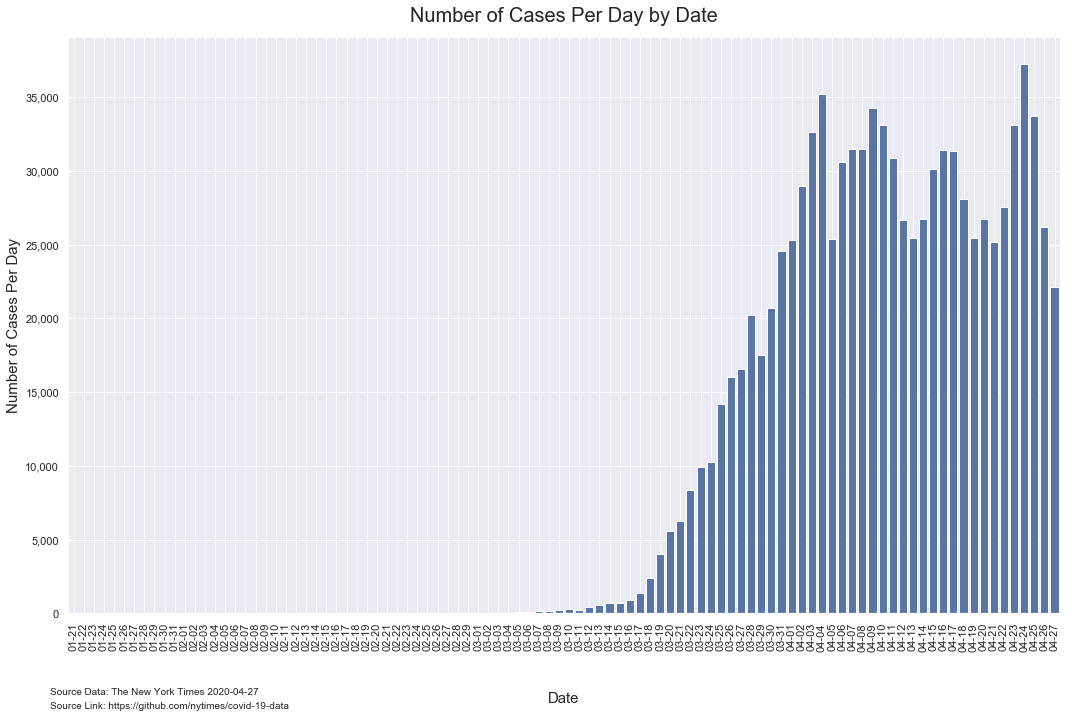

In [29]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.barplot(x="NewDate", 
            y="daily_cases",
            color="C0",
            data=epi_curve)

ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.labelpad = 40

ax1.grid(True)
ax1.grid(axis='x', which='minor')
plt.xticks(rotation=90)

#ax1.legend_.remove()
ax1.set_xlabel('Date', fontsize=15)
ax1.set_ylabel('Number of Cases Per Day', fontsize=15)
plt.title('Number of Cases Per Day by Date', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()

In [30]:
epi_curve['3_day_rolling_average'] = epi_curve.daily_cases.rolling(3).mean()

In [31]:
epi_curve

date   cases NewDate  daily_cases  3_day_rolling_average
0  2020-01-21       1   01-21          1.0                    NaN
1  2020-01-22       1   01-22          0.0                    NaN
2  2020-01-23       1   01-23          0.0               0.333333
3  2020-01-24       2   01-24          1.0               0.333333
4  2020-01-25       3   01-25          1.0               0.666667
..        ...     ...     ...          ...                    ...
93 2020-04-23  859915   04-23      33158.0           28642.000000
94 2020-04-24  897163   04-24      37248.0           32654.333333
95 2020-04-25  930907   04-25      33744.0           34716.666667
96 2020-04-26  957125   04-26      26218.0           32403.333333
97 2020-04-27  979266   04-27      22141.0           27367.666667

[98 rows x 5 columns]

In [32]:
epi_curve['3_day_rolling_average'].fillna(0, inplace=True)

In [33]:
epi_curve.head()

date  cases NewDate  daily_cases  3_day_rolling_average
0 2020-01-21      1   01-21          1.0               0.000000
1 2020-01-22      1   01-22          0.0               0.000000
2 2020-01-23      1   01-23          0.0               0.333333
3 2020-01-24      2   01-24          1.0               0.333333
4 2020-01-25      3   01-25          1.0               0.666667

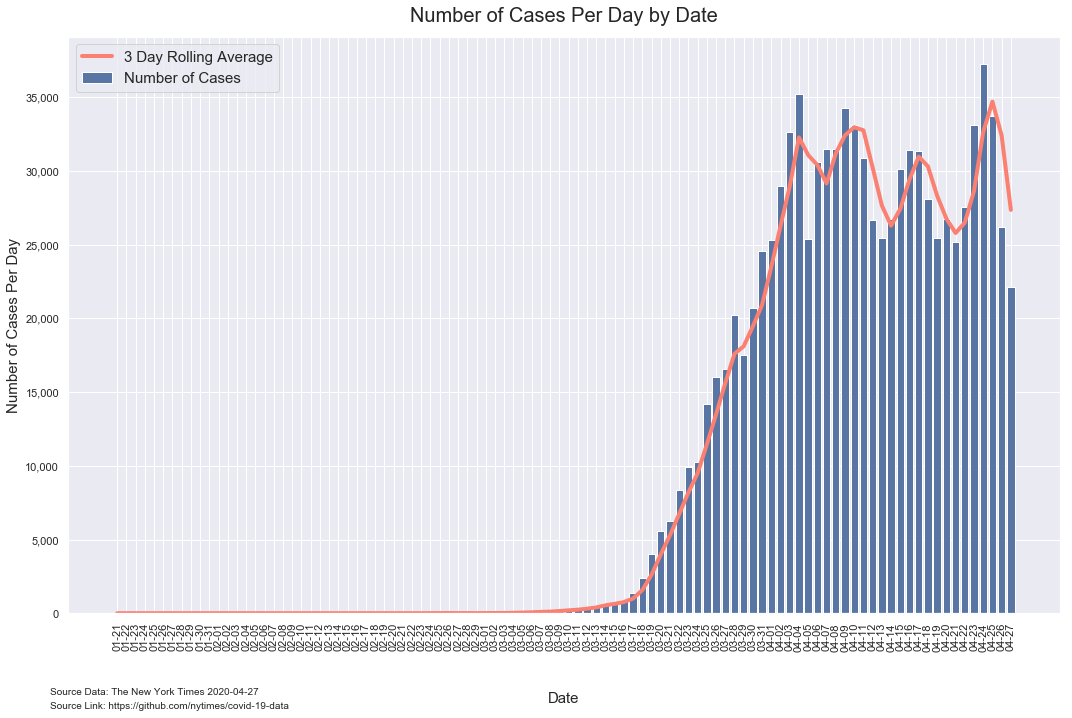

In [34]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.barplot(x="NewDate", 
            y="daily_cases",
            color="C0",
            data=epi_curve,
            label = 'Number of Cases')

sns.lineplot(x="NewDate", 
            y="3_day_rolling_average",
            color="salmon",
            data=epi_curve, 
            linewidth=4,
            label = '3 Day Rolling Average')

ax1.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0), interval=1))
ax1.xaxis.set_minor_formatter(dates.DateFormatter('D'))
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.labelpad = 40

ax1.grid(True)
ax1.grid(axis='x', which='minor')
plt.xticks(rotation=90)

leg = ax1.legend(loc='upper left', fontsize=15)

ax1.set_xlabel('Date', fontsize=15)
ax1.set_ylabel('Number of Cases Per Day', fontsize=15)
plt.title('Number of Cases Per Day by Date', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/epi_curve')

In [35]:
drop_duplicates = covid_19_counties_data.sort_values(by="cases", ascending=False).drop_duplicates(
                                                    subset ="county_name", keep = 'first')
top_10 = drop_duplicates[0:10]
top10_list = list(top_10.county_name)
top_10  = covid_19_counties_data.loc[covid_19_counties_data['county_name'].isin(top10_list)]

In [36]:
top_10

date         county       state     fips   cases  deaths  \
3     2020-01-24           Cook    Illinois  17031.0       1       0   
6     2020-01-25           Cook    Illinois  17031.0       1       0   
9     2020-01-26    Los Angeles  California   6037.0       1       0   
11    2020-01-26           Cook    Illinois  17031.0       1       0   
14    2020-01-27    Los Angeles  California   6037.0       1       0   
...          ...            ...         ...      ...     ...     ...   
94192 2020-04-27         Hudson  New Jersey  34017.0   13925     673   
94263 2020-04-27         Nassau    New York  36059.0   34865    2003   
94264 2020-04-27  New York City    New York      NaN  160499   11857   
94283 2020-04-27        Suffolk    New York  36103.0   32470    1147   
94291 2020-04-27    Westchester    New York  36119.0   28007    1077   

                   county_name  
3               Cook, Illinois  
6               Cook, Illinois  
9      Los Angeles, California  
11              Cook, Illinois  
14     Los Angeles, California  
...                        ...  
94192       Hudson, New Jersey  
94263         Nassau, New York  
94264  New York City, New York  
94283        Suffolk, New York  
94291    Westchester, New York  

[607 rows x 7 columns]

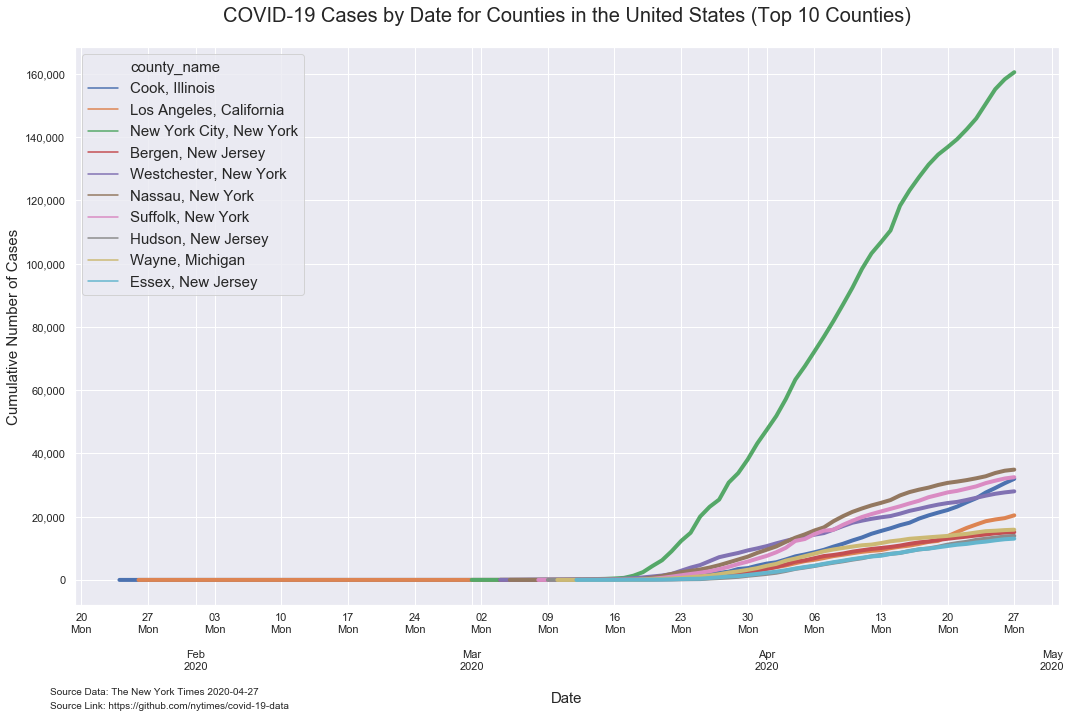

In [37]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="date", y="cases",
             hue="county_name",
             data=top_10, linewidth=4, ci=False)

ax1.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0), interval=1))
ax1.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax1.xaxis.grid(True, which="major")
ax1.xaxis.set_major_locator(dates.MonthLocator())
ax1.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.labelpad = 20

ax1.grid(True)
ax1.grid(axis='x', which='minor')

ax1.legend(fontsize=15)
ax1.set_xlabel('Date', fontsize=15)
ax1.set_ylabel('Cumulative Number of Cases', fontsize=15)
plt.title('COVID-19 Cases by Date for Counties in the United States (Top 10 Counties)', pad = 25, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/county-timeseries-top10')

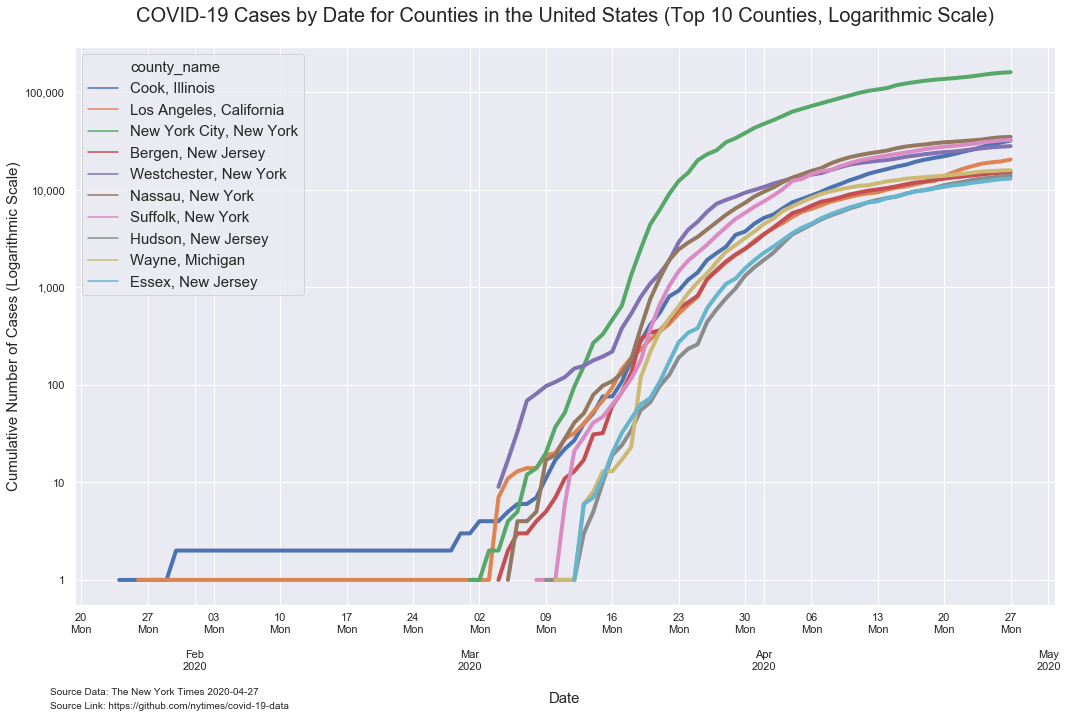

In [38]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="date", y="cases",
             hue="county_name",
             data=top_10, linewidth=4, ci=False)

ax1.set_yscale('log')

ax1.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0), interval=1))
ax1.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax1.xaxis.grid(True, which="major")
ax1.xaxis.set_major_locator(dates.MonthLocator())
ax1.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.labelpad = 20

ax1.grid(True)
ax1.grid(axis='x', which='minor')

ax1.legend(fontsize=15)
ax1.set_xlabel('Date', fontsize=15)
ax1.set_ylabel('Cumulative Number of Cases (Logarithmic Scale)', fontsize=15)
plt.title('COVID-19 Cases by Date for Counties in the United States (Top 10 Counties, Logarithmic Scale)', pad = 25, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/county-timeseries-top10-log')

# Date to 10 Cases

In [39]:
county_ten_cases = top_10.loc[top_10.cases >= 10]

In [40]:
county_ten_cases = county_ten_cases.sort_values(by=['date', 'cases'], 
                                              ascending=[True, True]).drop_duplicates(subset ="county_name", 
                                                                                      keep = 'first').reset_index(drop=True)

In [41]:
county_ten_cases = county_ten_cases[['date', 'county_name']]
county_ten_cases.rename(columns={'date': 'date_ten_case'}, inplace=True)

In [42]:
county_ten_cases

date_ten_case              county_name
0    2020-03-05  Los Angeles, California
1    2020-03-05    Westchester, New York
2    2020-03-07  New York City, New York
3    2020-03-09           Cook, Illinois
4    2020-03-09         Nassau, New York
5    2020-03-11       Bergen, New Jersey
6    2020-03-12        Suffolk, New York
7    2020-03-15       Hudson, New Jersey
8    2020-03-15        Essex, New Jersey
9    2020-03-15          Wayne, Michigan

In [43]:
county_ten_cases = top_10.merge(county_ten_cases, left_on='county_name', right_on='county_name')

In [44]:
county_ten_cases

date county       state     fips  cases  deaths        county_name  \
0   2020-01-24   Cook    Illinois  17031.0      1       0     Cook, Illinois   
1   2020-01-25   Cook    Illinois  17031.0      1       0     Cook, Illinois   
2   2020-01-26   Cook    Illinois  17031.0      1       0     Cook, Illinois   
3   2020-01-27   Cook    Illinois  17031.0      1       0     Cook, Illinois   
4   2020-01-28   Cook    Illinois  17031.0      1       0     Cook, Illinois   
..         ...    ...         ...      ...    ...     ...                ...   
602 2020-04-23  Essex  New Jersey  34013.0  11811     932  Essex, New Jersey   
603 2020-04-24  Essex  New Jersey  34013.0  12110     975  Essex, New Jersey   
604 2020-04-25  Essex  New Jersey  34013.0  12520    1019  Essex, New Jersey   
605 2020-04-26  Essex  New Jersey  34013.0  12863    1023  Essex, New Jersey   
606 2020-04-27  Essex  New Jersey  34013.0  13047    1028  Essex, New Jersey   

    date_ten_case  
0      2020-03-09  
1      2020-03-09  
2      2020-03-09  
3      2020-03-09  
4      2020-03-09  
..            ...  
602    2020-03-15  
603    2020-03-15  
604    2020-03-15  
605    2020-03-15  
606    2020-03-15  

[607 rows x 8 columns]

In [45]:
county_ten_cases = county_ten_cases.loc[county_ten_cases.cases >= 10]

In [46]:
county_ten_cases

date county       state     fips  cases  deaths        county_name  \
45  2020-03-09   Cook    Illinois  17031.0     11       0     Cook, Illinois   
46  2020-03-10   Cook    Illinois  17031.0     17       0     Cook, Illinois   
47  2020-03-11   Cook    Illinois  17031.0     22       0     Cook, Illinois   
48  2020-03-12   Cook    Illinois  17031.0     27       0     Cook, Illinois   
49  2020-03-13   Cook    Illinois  17031.0     40       0     Cook, Illinois   
..         ...    ...         ...      ...    ...     ...                ...   
602 2020-04-23  Essex  New Jersey  34013.0  11811     932  Essex, New Jersey   
603 2020-04-24  Essex  New Jersey  34013.0  12110     975  Essex, New Jersey   
604 2020-04-25  Essex  New Jersey  34013.0  12520    1019  Essex, New Jersey   
605 2020-04-26  Essex  New Jersey  34013.0  12863    1023  Essex, New Jersey   
606 2020-04-27  Essex  New Jersey  34013.0  13047    1028  Essex, New Jersey   

    date_ten_case  
45     2020-03-09  
46     2020-03-09  
47     2020-03-09  
48     2020-03-09  
49     2020-03-09  
..            ...  
602    2020-03-15  
603    2020-03-15  
604    2020-03-15  
605    2020-03-15  
606    2020-03-15  

[487 rows x 8 columns]

In [47]:
county_ten_cases['days_since_ten_case'] = (county_ten_cases['date'] - 
                                      county_ten_cases['date_ten_case']).dt.days

/Users/geribauer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [48]:
county_ten_cases

date county       state     fips  cases  deaths        county_name  \
45  2020-03-09   Cook    Illinois  17031.0     11       0     Cook, Illinois   
46  2020-03-10   Cook    Illinois  17031.0     17       0     Cook, Illinois   
47  2020-03-11   Cook    Illinois  17031.0     22       0     Cook, Illinois   
48  2020-03-12   Cook    Illinois  17031.0     27       0     Cook, Illinois   
49  2020-03-13   Cook    Illinois  17031.0     40       0     Cook, Illinois   
..         ...    ...         ...      ...    ...     ...                ...   
602 2020-04-23  Essex  New Jersey  34013.0  11811     932  Essex, New Jersey   
603 2020-04-24  Essex  New Jersey  34013.0  12110     975  Essex, New Jersey   
604 2020-04-25  Essex  New Jersey  34013.0  12520    1019  Essex, New Jersey   
605 2020-04-26  Essex  New Jersey  34013.0  12863    1023  Essex, New Jersey   
606 2020-04-27  Essex  New Jersey  34013.0  13047    1028  Essex, New Jersey   

    date_ten_case  days_since_ten_case  
45     2020-03-09                    0  
46     2020-03-09                    1  
47     2020-03-09                    2  
48     2020-03-09                    3  
49     2020-03-09                    4  
..            ...                  ...  
602    2020-03-15                   39  
603    2020-03-15                   40  
604    2020-03-15                   41  
605    2020-03-15                   42  
606    2020-03-15                   43  

[487 rows x 9 columns]

# Daily Number of Cases Since 10th Case

In [49]:
county_ten_cases['daily_cases'] = (county_ten_cases.cases -
                                county_ten_cases.cases.shift(1))

/Users/geribauer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [50]:
county_ten_cases[:50]

date county     state     fips  cases  deaths     county_name  \
45 2020-03-09   Cook  Illinois  17031.0     11       0  Cook, Illinois   
46 2020-03-10   Cook  Illinois  17031.0     17       0  Cook, Illinois   
47 2020-03-11   Cook  Illinois  17031.0     22       0  Cook, Illinois   
48 2020-03-12   Cook  Illinois  17031.0     27       0  Cook, Illinois   
49 2020-03-13   Cook  Illinois  17031.0     40       0  Cook, Illinois   
50 2020-03-14   Cook  Illinois  17031.0     51       0  Cook, Illinois   
51 2020-03-15   Cook  Illinois  17031.0     76       0  Cook, Illinois   
52 2020-03-16   Cook  Illinois  17031.0     76       0  Cook, Illinois   
53 2020-03-17   Cook  Illinois  17031.0    107       1  Cook, Illinois   
54 2020-03-18   Cook  Illinois  17031.0    179       1  Cook, Illinois   
55 2020-03-19   Cook  Illinois  17031.0    279       2  Cook, Illinois   
56 2020-03-20   Cook  Illinois  17031.0    412       3  Cook, Illinois   
57 2020-03-21   Cook  Illinois  17031.0    548       4  Cook, Illinois   
58 2020-03-22   Cook  Illinois  17031.0    805       6  Cook, Illinois   
59 2020-03-23   Cook  Illinois  17031.0    922       9  Cook, Illinois   
60 2020-03-24   Cook  Illinois  17031.0   1194      12  Cook, Illinois   
61 2020-03-25   Cook  Illinois  17031.0   1418      13  Cook, Illinois   
62 2020-03-26   Cook  Illinois  17031.0   1904      18  Cook, Illinois   
63 2020-03-27   Cook  Illinois  17031.0   2239      20  Cook, Illinois   
64 2020-03-28   Cook  Illinois  17031.0   2613      28  Cook, Illinois   
65 2020-03-29   Cook  Illinois  17031.0   3445      40  Cook, Illinois   
66 2020-03-30   Cook  Illinois  17031.0   3727      44  Cook, Illinois   
67 2020-03-31   Cook  Illinois  17031.0   4496      61  Cook, Illinois   
68 2020-04-01   Cook  Illinois  17031.0   5152      95  Cook, Illinois   
69 2020-04-02   Cook  Illinois  17031.0   5575     107  Cook, Illinois   
70 2020-04-03   Cook  Illinois  17031.0   6473     141  Cook, Illinois   
71 2020-04-04   Cook  Illinois  17031.0   7439     167  Cook, Illinois   
72 2020-04-05   Cook  Illinois  17031.0   8043     186  Cook, Illinois   
73 2020-04-06   Cook  Illinois  17031.0   8728     209  Cook, Illinois   
74 2020-04-07   Cook  Illinois  17031.0   9509     249  Cook, Illinois   
75 2020-04-08   Cook  Illinois  17031.0  10520     312  Cook, Illinois   
76 2020-04-09   Cook  Illinois  17031.0  11415     351  Cook, Illinois   
77 2020-04-10   Cook  Illinois  17031.0  12472     398  Cook, Illinois   
78 2020-04-11   Cook  Illinois  17031.0  13417     453  Cook, Illinois   
79 2020-04-12   Cook  Illinois  17031.0  14585     485  Cook, Illinois   
80 2020-04-13   Cook  Illinois  17031.0  15474     543  Cook, Illinois   
81 2020-04-14   Cook  Illinois  17031.0  16323     577  Cook, Illinois   
82 2020-04-15   Cook  Illinois  17031.0  17306     630  Cook, Illinois   
83 2020-04-16   Cook  Illinois  17031.0  18087     722  Cook, Illinois   
84 2020-04-17   Cook  Illinois  17031.0  19391     760  Cook, Illinois   
85 2020-04-18   Cook  Illinois  17031.0  20395     860  Cook, Illinois   
86 2020-04-19   Cook  Illinois  17031.0  21272     877  Cook, Illinois   
87 2020-04-20   Cook  Illinois  17031.0  22101     915  Cook, Illinois   
88 2020-04-21   Cook  Illinois  17031.0  23181    1002  Cook, Illinois   
89 2020-04-22   Cook  Illinois  17031.0  24546    1072  Cook, Illinois   
90 2020-04-23   Cook  Illinois  17031.0  25811    1142  Cook, Illinois   
91 2020-04-24   Cook  Illinois  17031.0  27616    1220  Cook, Illinois   
92 2020-04-25   Cook  Illinois  17031.0  29058    1267  Cook, Illinois   
93 2020-04-26   Cook  Illinois  17031.0  30574    1313  Cook, Illinois   
94 2020-04-27   Cook  Illinois  17031.0  31953    1347  Cook, Illinois   

   date_ten_case  days_since_ten_case  daily_cases  
45    2020-03-09                    0          NaN  
46    2020-03-09                    1          6.0  
47    2020-03-09                    2          5.0  
48    2020-03-09      

In [51]:
county_ten_cases.columns

Index(['date', 'county', 'state', 'fips', 'cases', 'deaths', 'county_name',
       'date_ten_case', 'days_since_ten_case', 'daily_cases'],
      dtype='object')

In [52]:
county_ten_cases = county_ten_cases[['date', 'county', 'county_name', 'cases',  
                                   'daily_cases', 'deaths', 'date_ten_case','days_since_ten_case']]

In [53]:
county_ten_cases[250:300]

date       county            county_name  cases  daily_cases  \
348 2020-04-20  Westchester  Westchester, New York  24306        503.0   
349 2020-04-21  Westchester  Westchester, New York  24655        349.0   
350 2020-04-22  Westchester  Westchester, New York  25275        620.0   
351 2020-04-23  Westchester  Westchester, New York  25959        684.0   
352 2020-04-24  Westchester  Westchester, New York  26632        673.0   
353 2020-04-25  Westchester  Westchester, New York  27230        598.0   
354 2020-04-26  Westchester  Westchester, New York  27664        434.0   
355 2020-04-27  Westchester  Westchester, New York  28007        343.0   
360 2020-03-09       Nassau       Nassau, New York     17     -27990.0   
361 2020-03-10       Nassau       Nassau, New York     19          2.0   
362 2020-03-11       Nassau       Nassau, New York     28          9.0   
363 2020-03-12       Nassau       Nassau, New York     41         13.0   
364 2020-03-13       Nassau       Nassau, New York     51         10.0   
365 2020-03-14       Nassau       Nassau, New York     79         28.0   
366 2020-03-15       Nassau       Nassau, New York     98         19.0   
367 2020-03-16       Nassau       Nassau, New York    109         11.0   
368 2020-03-17       Nassau       Nassau, New York    131         22.0   
369 2020-03-18       Nassau       Nassau, New York    183         52.0   
370 2020-03-19       Nassau       Nassau, New York    382        199.0   
371 2020-03-20       Nassau       Nassau, New York    754        372.0   
372 2020-03-21       Nassau       Nassau, New York   1234        480.0   
373 2020-03-22       Nassau       Nassau, New York   1900        666.0   
374 2020-03-23       Nassau       Nassau, New York   2442        542.0   
375 2020-03-24       Nassau       Nassau, New York   2869        427.0   
376 2020-03-25       Nassau       Nassau, New York   3285        416.0   
377 2020-03-26       Nassau       Nassau, New York   3914        629.0   
378 2020-03-27       Nassau       Nassau, New York   4657        743.0   
379 2020-03-28       Nassau       Nassau, New York   5537        880.0   
380 2020-03-29       Nassau       Nassau, New York   6445        908.0   
381 2020-03-30       Nassau       Nassau, New York   7344        899.0   
382 2020-03-31       Nassau       Nassau, New York   8544       1200.0   
383 2020-04-01       Nassau       Nassau, New York   9555       1011.0   
384 2020-04-02       Nassau       Nassau, New York  10587       1032.0   
385 2020-04-03       Nassau       Nassau, New York  12024       1437.0   
386 2020-04-04       Nassau       Nassau, New York  13346       1322.0   
387 2020-04-05       Nassau       Nassau, New York  14398       1052.0   
388 2020-04-06       Nassau       Nassau, New York  15616       1218.0   
389 2020-04-07       Nassau       Nassau, New York  16610        994.0   
390 2020-04-08       Nassau       Nassau, New York  18548       1938.0   
391 2020-04-09       Nassau       Nassau, New York  20140       1592.0   
392 2020-04-10       Nassau       Nassau, New York  21512       1372.0   
393 2020-04-11       Nassau       Nassau, New York  22584       1072.0   
394 2020-04-12       Nassau       Nassau, New York  23553        969.0   
395 2020-04-13       Nassau       Nassau, New York  24358        805.0   
396 2020-04-14       Nassau       Nassau, New York  25250        892.0   
397 2020-04-15       Nassau       Nassau, New York  26715       1465.0   
398 2020-04-16       Nassau       Nassau, New York  27772       1057.0   
399 2020-04-17       Nassau       Nassau, New York  28539        767.0   
400 2020-04-18       Nassau       Nassau, New York  29180        641.0   
401 2020-04-19       Nassau       Nassau, New York  30013        833.0   

     deaths date_ten_case  days_since_ten_case  
348     867    2020-03-05                   46  
349     904    2020-03-05                   47  
350     932    2020-03-05                   48  
351     962    2020-03-05              

In [54]:
county_ten_cases['daily_cases'].loc[county_ten_cases.daily_cases < 0] = county_ten_cases['cases'] - 10

/Users/geribauer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [55]:
county_ten_cases['daily_cases'].loc[county_ten_cases.daily_cases.isnull()] = county_ten_cases['cases'] - 10

/Users/geribauer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [56]:
county_ten_cases[:50]

date county     county_name  cases  daily_cases  deaths  \
45 2020-03-09   Cook  Cook, Illinois     11          1.0       0   
46 2020-03-10   Cook  Cook, Illinois     17          6.0       0   
47 2020-03-11   Cook  Cook, Illinois     22          5.0       0   
48 2020-03-12   Cook  Cook, Illinois     27          5.0       0   
49 2020-03-13   Cook  Cook, Illinois     40         13.0       0   
50 2020-03-14   Cook  Cook, Illinois     51         11.0       0   
51 2020-03-15   Cook  Cook, Illinois     76         25.0       0   
52 2020-03-16   Cook  Cook, Illinois     76          0.0       0   
53 2020-03-17   Cook  Cook, Illinois    107         31.0       1   
54 2020-03-18   Cook  Cook, Illinois    179         72.0       1   
55 2020-03-19   Cook  Cook, Illinois    279        100.0       2   
56 2020-03-20   Cook  Cook, Illinois    412        133.0       3   
57 2020-03-21   Cook  Cook, Illinois    548        136.0       4   
58 2020-03-22   Cook  Cook, Illinois    805        257.0       6   
59 2020-03-23   Cook  Cook, Illinois    922        117.0       9   
60 2020-03-24   Cook  Cook, Illinois   1194        272.0      12   
61 2020-03-25   Cook  Cook, Illinois   1418        224.0      13   
62 2020-03-26   Cook  Cook, Illinois   1904        486.0      18   
63 2020-03-27   Cook  Cook, Illinois   2239        335.0      20   
64 2020-03-28   Cook  Cook, Illinois   2613        374.0      28   
65 2020-03-29   Cook  Cook, Illinois   3445        832.0      40   
66 2020-03-30   Cook  Cook, Illinois   3727        282.0      44   
67 2020-03-31   Cook  Cook, Illinois   4496        769.0      61   
68 2020-04-01   Cook  Cook, Illinois   5152        656.0      95   
69 2020-04-02   Cook  Cook, Illinois   5575        423.0     107   
70 2020-04-03   Cook  Cook, Illinois   6473        898.0     141   
71 2020-04-04   Cook  Cook, Illinois   7439        966.0     167   
72 2020-04-05   Cook  Cook, Illinois   8043        604.0     186   
73 2020-04-06   Cook  Cook, Illinois   8728        685.0     209   
74 2020-04-07   Cook  Cook, Illinois   9509        781.0     249   
75 2020-04-08   Cook  Cook, Illinois  10520       1011.0     312   
76 2020-04-09   Cook  Cook, Illinois  11415        895.0     351   
77 2020-04-10   Cook  Cook, Illinois  12472       1057.0     398   
78 2020-04-11   Cook  Cook, Illinois  13417        945.0     453   
79 2020-04-12   Cook  Cook, Illinois  14585       1168.0     485   
80 2020-04-13   Cook  Cook, Illinois  15474        889.0     543   
81 2020-04-14   Cook  Cook, Illinois  16323        849.0     577   
82 2020-04-15   Cook  Cook, Illinois  17306        983.0     630   
83 2020-04-16   Cook  Cook, Illinois  18087        781.0     722   
84 2020-04-17   Cook  Cook, Illinois  19391       1304.0     760   
85 2020-04-18   Cook  Cook, Illinois  20395       1004.0     860   
86 2020-04-19   Cook  Cook, Illinois  21272        877.0     877   
87 2020-04-20   Cook  Cook, Illinois  22101        829.0     915   
88 2020-04-21   Cook  Cook, Illinois  23181       1080.0    1002   
89 2020-04-22   Cook  Cook, Illinois  24546       1365.0    1072   
90 2020-04-23   Cook  Cook, Illinois  25811       1265.0    1142   
91 2020-04-24   Cook  Cook, Illinois  27616       1805.0    1220   
92 2020-04-25   Cook  Cook, Illinois  29058       1442.0    1267   
93 2020-04-26   Cook  Cook, Illinois  30574       1516.0    1313   
94 2020-04-27   Cook  Cook, Illinois  31953       1379.0    1347   

   date_ten_case  days_since_ten_case  
45    2020-03-09                    0  
46    2020-03-09                    1  
47    2020-03-09                    2  
48    2020-03-09                    3  
49    2020-03-09                    4  
50    2020-03-09                    5  
51    2020-03-09                    6  
52    2020-03-09                    7  
53    2020-03-09                    8  
54    2020-03-09                    9  
55    2020-03-09                   10  
56    2020-03-09                   11  
57    2020-03-09    

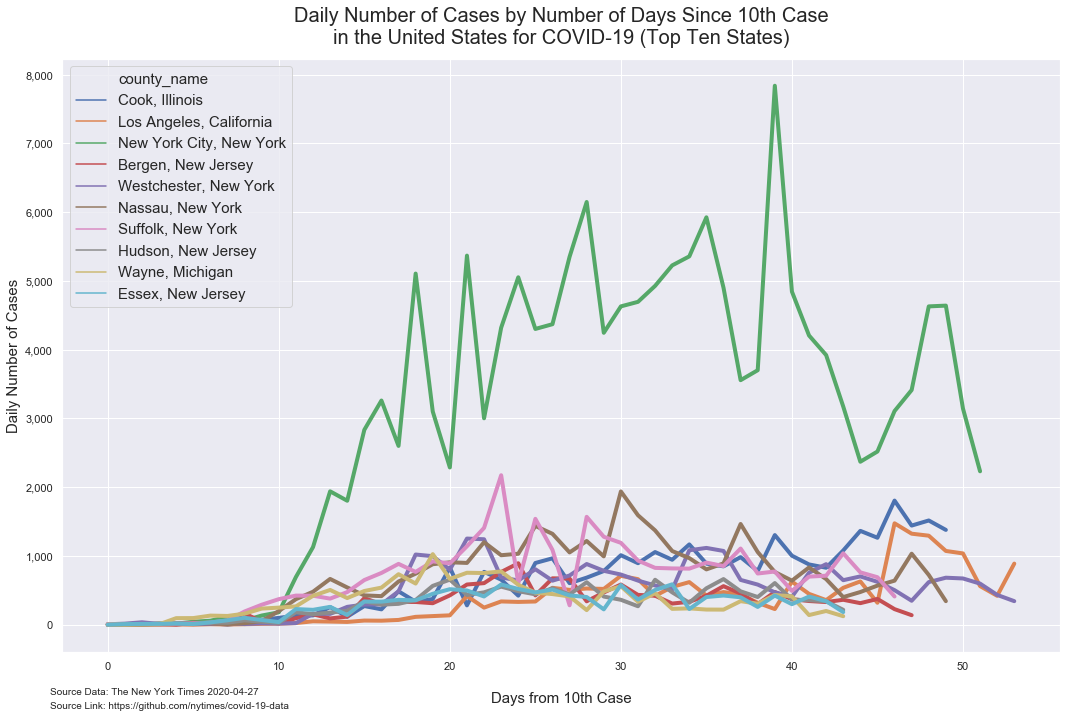

In [57]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="days_since_ten_case", y="daily_cases",
             hue="county_name",
             data=county_ten_cases, linewidth=4)

ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.labelpad = 20

ax1.grid(True)
ax1.grid(axis='x', which='minor')

ax1.legend(loc='upper left', fontsize=15)
ax1.set_xlabel('Days from 10th Case', fontsize=15)
ax1.set_ylabel('Daily Number of Cases', fontsize=15)
plt.title('Daily Number of Cases by Number of Days Since 10th Case\nin the United States for COVID-19 (Top Ten States)', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/10-cases-timeseries-by-county-top-10-daily')

In [58]:
county_ten_cases['daily_cases'].loc[county_ten_cases.daily_cases == 0]

52     0.0
137    0.0
467    0.0
517    0.0
Name: daily_cases, dtype: float64

In [59]:
temp_fill_zeros = county_ten_cases.sort_values(by=['county_name', 'date','cases'], 
                                                 ascending=[True, True, True])

temp_fill_zeros['daily_cases'].loc[temp_fill_zeros.daily_cases == 0] = 1

temp_fill_zeros

date       county            county_name  cases  daily_cases  \
253 2020-03-11       Bergen     Bergen, New Jersey     11          1.0   
254 2020-03-12       Bergen     Bergen, New Jersey     13          2.0   
255 2020-03-13       Bergen     Bergen, New Jersey     17          4.0   
256 2020-03-14       Bergen     Bergen, New Jersey     31         14.0   
257 2020-03-15       Bergen     Bergen, New Jersey     32          1.0   
..         ...          ...                    ...    ...          ...   
351 2020-04-23  Westchester  Westchester, New York  25959        684.0   
352 2020-04-24  Westchester  Westchester, New York  26632        673.0   
353 2020-04-25  Westchester  Westchester, New York  27230        598.0   
354 2020-04-26  Westchester  Westchester, New York  27664        434.0   
355 2020-04-27  Westchester  Westchester, New York  28007        343.0   

     deaths date_ten_case  days_since_ten_case  
253       1    2020-03-11                    0  
254       1    2020-03-11                    1  
255       1    2020-03-11                    2  
256       1    2020-03-11                    3  
257       1    2020-03-11                    4  
..      ...           ...                  ...  
351     962    2020-03-05                   49  
352     989    2020-03-05                   50  
353    1022    2020-03-05                   51  
354    1054    2020-03-05                   52  
355    1077    2020-03-05                   53  

[487 rows x 8 columns]

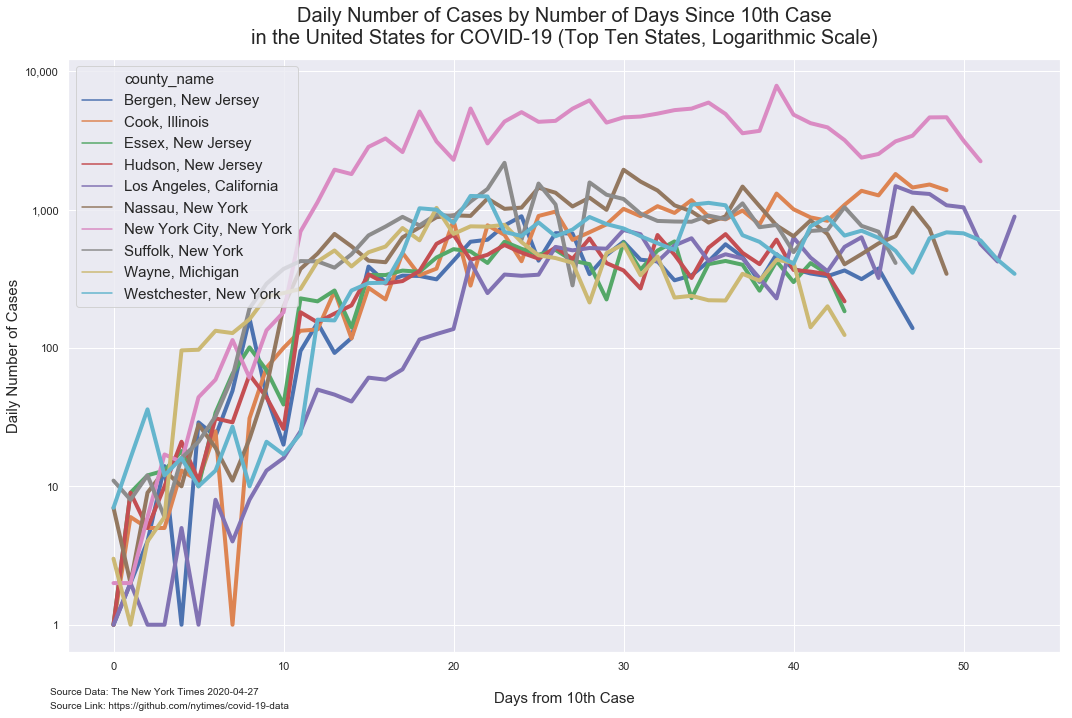

In [60]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')
sns.lineplot(x="days_since_ten_case", y="daily_cases",
             hue="county_name",
             data=temp_fill_zeros, linewidth=4)

ax1.set_yscale('log')

ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.labelpad = 20

ax1.grid(True)
ax1.grid(axis='x', which='minor')

ax1.legend(loc='upper left', fontsize=15)
ax1.set_xlabel('Days from 10th Case', fontsize=15)
ax1.set_ylabel('Daily Number of Cases', fontsize=15)
plt.title('Daily Number of Cases by Number of Days Since 10th Case\nin the United States for COVID-19 (Top Ten States, Logarithmic Scale)', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/10-cases-timeseries-by-county-top-10-daily-log')

In [61]:
county_ten_cases['daily_cases'].loc[county_ten_cases.daily_cases == 0]

52     0.0
137    0.0
467    0.0
517    0.0
Name: daily_cases, dtype: float64

# Daily Number of Cases Since 10th Case (Weekly Average)

In [62]:
county_ten_cases_weekly = county_ten_cases.sort_values(by=['county_name', 'date','cases'], 
                                                    ascending=[True, True, True])

In [63]:
county_ten_cases_weekly[0:30]

date  county         county_name  cases  daily_cases  deaths  \
253 2020-03-11  Bergen  Bergen, New Jersey     11          1.0       1   
254 2020-03-12  Bergen  Bergen, New Jersey     13          2.0       1   
255 2020-03-13  Bergen  Bergen, New Jersey     17          4.0       1   
256 2020-03-14  Bergen  Bergen, New Jersey     31         14.0       1   
257 2020-03-15  Bergen  Bergen, New Jersey     32          1.0       1   
258 2020-03-16  Bergen  Bergen, New Jersey     61         29.0       2   
259 2020-03-17  Bergen  Bergen, New Jersey     84         23.0       2   
260 2020-03-18  Bergen  Bergen, New Jersey    133         49.0       4   
261 2020-03-19  Bergen  Bergen, New Jersey    297        164.0       6   
262 2020-03-20  Bergen  Bergen, New Jersey    342         45.0       7   
263 2020-03-21  Bergen  Bergen, New Jersey    362         20.0       9   
264 2020-03-22  Bergen  Bergen, New Jersey    457         95.0      10   
265 2020-03-23  Bergen  Bergen, New Jersey    609        152.0      12   
266 2020-03-24  Bergen  Bergen, New Jersey    701         92.0      14   
267 2020-03-25  Bergen  Bergen, New Jersey    819        118.0      15   
268 2020-03-26  Bergen  Bergen, New Jersey   1206        387.0      21   
269 2020-03-27  Bergen  Bergen, New Jersey   1505        299.0      28   
270 2020-03-28  Bergen  Bergen, New Jersey   1838        333.0      35   
271 2020-03-29  Bergen  Bergen, New Jersey   2169        331.0      35   
272 2020-03-30  Bergen  Bergen, New Jersey   2482        313.0      41   
273 2020-03-31  Bergen  Bergen, New Jersey   2909        427.0      53   
274 2020-04-01  Bergen  Bergen, New Jersey   3494        585.0      75   
275 2020-04-02  Bergen  Bergen, New Jersey   4099        605.0     120   
276 2020-04-03  Bergen  Bergen, New Jersey   4866        767.0     132   
277 2020-04-04  Bergen  Bergen, New Jersey   5760        894.0     179   
278 2020-04-05  Bergen  Bergen, New Jersey   6187        427.0     189   
279 2020-04-06  Bergen  Bergen, New Jersey   6862        675.0     200   
280 2020-04-07  Bergen  Bergen, New Jersey   7533        671.0     263   
281 2020-04-08  Bergen  Bergen, New Jersey   7874        341.0     314   
282 2020-04-09  Bergen  Bergen, New Jersey   8343        469.0     345   

    date_ten_case  days_since_ten_case  
253    2020-03-11                    0  
254    2020-03-11                    1  
255    2020-03-11                    2  
256    2020-03-11                    3  
257    2020-03-11                    4  
258    2020-03-11                    5  
259    2020-03-11                    6  
260    2020-03-11                    7  
261    2020-03-11                    8  
262    2020-03-11                    9  
263    2020-03-11                   10  
264    2020-03-11                   11  
265    2020-03-11                   12  
266    2020-03-11                   13  
267    2020-03-11                   14  
268    2020-03-11                   15  
269    2020-03-11                   16  
270    2020-03-11                   17  
271    2020-03-11                   18  
272    2020-03-11                   19  
273    2020-03-11                   20  
274    2020-03-11                   21  
275    2020-03-11                   22  
276    2020-03-11                   23  
277    2020-03-11                   24  
278    2020-03-11                   25  
279    2020-03-11                   26  
280    2020-03-11                   27  
281    2020-03-11                   28  
282    2020-03-11                   29

In [64]:
county_ten_cases_weekly = county_ten_cases_weekly.set_index('date').groupby('county_name').resample('W').agg({'days_since_ten_case': 
                                                                    np.max, 'daily_cases': np.mean})

In [65]:
county_ten_cases_weekly

days_since_ten_case  daily_cases
county_name           date                                        
Bergen, New Jersey    2020-03-15                    4     4.400000
                      2020-03-22                   11    60.714286
                      2020-03-29                   18   244.571429
                      2020-04-05                   25   574.000000
                      2020-04-12                   32   513.857143
...                                               ...          ...
Westchester, New York 2020-04-05                   31   743.285714
                      2020-04-12                   38   798.714286
                      2020-04-19                   45   641.428571
                      2020-04-26                   52   551.571429
                      2020-05-03                   53   343.000000

[83 rows x 2 columns]

In [66]:
county_ten_cases_weekly.reset_index(inplace=True)
county_ten_cases_weekly.rename(columns={'daily_cases': 'daily_cases_week_average'}, inplace=True)

In [67]:
county_ten_cases_weekly

county_name       date  days_since_ten_case  \
0      Bergen, New Jersey 2020-03-15                    4   
1      Bergen, New Jersey 2020-03-22                   11   
2      Bergen, New Jersey 2020-03-29                   18   
3      Bergen, New Jersey 2020-04-05                   25   
4      Bergen, New Jersey 2020-04-12                   32   
..                    ...        ...                  ...   
78  Westchester, New York 2020-04-05                   31   
79  Westchester, New York 2020-04-12                   38   
80  Westchester, New York 2020-04-19                   45   
81  Westchester, New York 2020-04-26                   52   
82  Westchester, New York 2020-05-03                   53   

    daily_cases_week_average  
0                   4.400000  
1                  60.714286  
2                 244.571429  
3                 574.000000  
4                 513.857143  
..                       ...  
78                743.285714  
79                798.714286  
80                641.428571  
81                551.571429  
82                343.000000  

[83 rows x 4 columns]

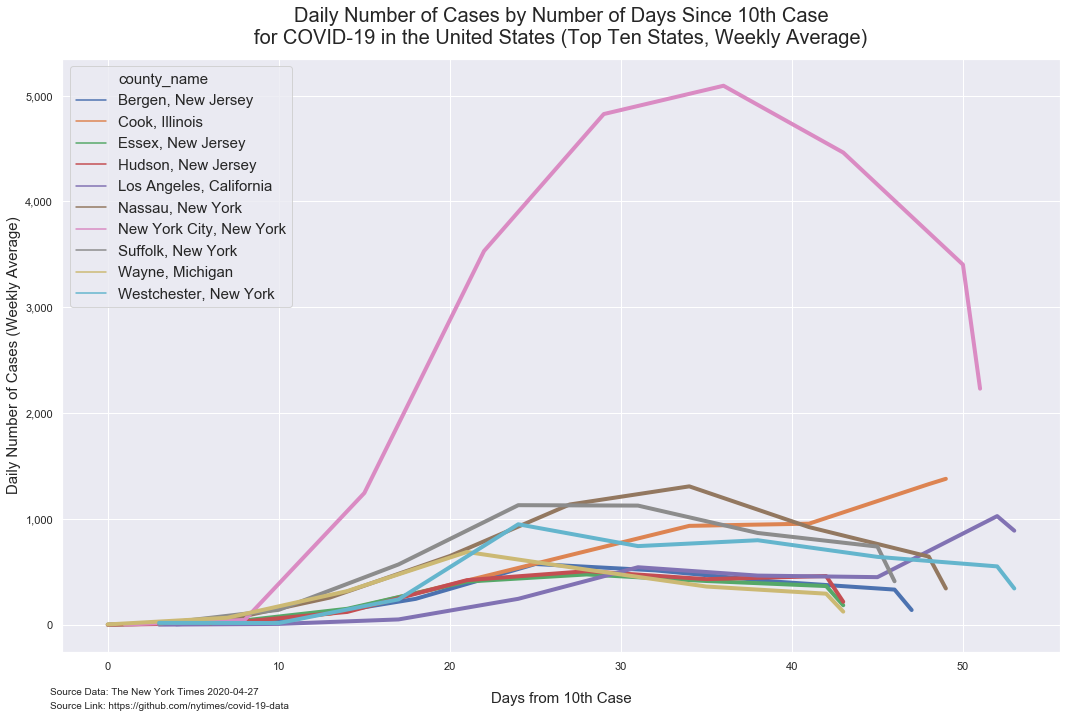

In [68]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')
sns.lineplot(x="days_since_ten_case", y="daily_cases_week_average",
             hue="county_name",
             data=county_ten_cases_weekly, linewidth=4)

ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.labelpad = 20

ax1.grid(True)
ax1.grid(axis='x', which='minor')

ax1.legend(loc='upper left', fontsize=15)
ax1.set_xlabel('Days from 10th Case', fontsize=15)
ax1.set_ylabel('Daily Number of Cases (Weekly Average)', fontsize=15)
plt.title('Daily Number of Cases by Number of Days Since 10th Case\nfor COVID-19 in the United States (Top Ten States, Weekly Average)', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/10-cases-timeseries-by-county-top-10-weekly')

In [69]:
county_ten_cases_weekly.sort_values(by='daily_cases_week_average')

county_name       date  days_since_ten_case  \
24       Hudson, New Jersey 2020-03-15                    0   
32  Los Angeles, California 2020-03-08                    3   
16        Essex, New Jersey 2020-03-15                    0   
49  New York City, New York 2020-03-08                    1   
66          Wayne, Michigan 2020-03-15                    0   
..                      ...        ...                  ...   
56  New York City, New York 2020-04-26                   50   
52  New York City, New York 2020-03-29                   22   
55  New York City, New York 2020-04-19                   43   
53  New York City, New York 2020-04-05                   29   
54  New York City, New York 2020-04-12                   36   

    daily_cases_week_average  
24                  0.000000  
32                  1.000000  
16                  1.000000  
49                  2.000000  
66                  3.000000  
..                       ...  
56               3403.142857  
52               3531.857143  
55               4462.571429  
53               4826.285714  
54               5093.714286  

[83 rows x 4 columns]

In [70]:
temp_fill_zeros = county_ten_cases_weekly.sort_values(by=['county_name', 'date','daily_cases_week_average'], 
                                                 ascending=[True, True, True])

temp_fill_zeros['daily_cases_week_average'].loc[temp_fill_zeros.daily_cases_week_average == 0] = 1

temp_fill_zeros

county_name       date  days_since_ten_case  \
0      Bergen, New Jersey 2020-03-15                    4   
1      Bergen, New Jersey 2020-03-22                   11   
2      Bergen, New Jersey 2020-03-29                   18   
3      Bergen, New Jersey 2020-04-05                   25   
4      Bergen, New Jersey 2020-04-12                   32   
..                    ...        ...                  ...   
78  Westchester, New York 2020-04-05                   31   
79  Westchester, New York 2020-04-12                   38   
80  Westchester, New York 2020-04-19                   45   
81  Westchester, New York 2020-04-26                   52   
82  Westchester, New York 2020-05-03                   53   

    daily_cases_week_average  
0                   4.400000  
1                  60.714286  
2                 244.571429  
3                 574.000000  
4                 513.857143  
..                       ...  
78                743.285714  
79                798.714286  
80                641.428571  
81                551.571429  
82                343.000000  

[83 rows x 4 columns]

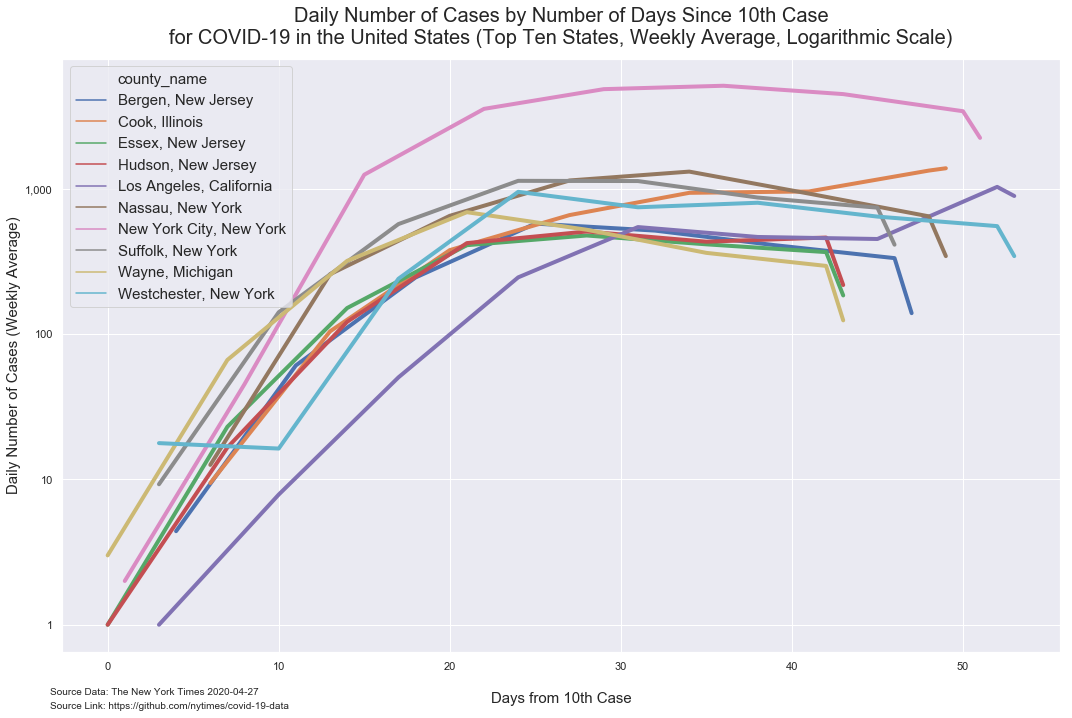

In [71]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="days_since_ten_case", y="daily_cases_week_average",
             hue="county_name",
             data=temp_fill_zeros, linewidth=4)

ax1.set_yscale('log')

ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.labelpad = 20

ax1.grid(True)
ax1.grid(axis='x', which='minor')

ax1.legend(loc='upper left', fontsize=15)
ax1.set_xlabel('Days from 10th Case', fontsize=15)
ax1.set_ylabel('Daily Number of Cases (Weekly Average)', fontsize=15)
plt.title('Daily Number of Cases by Number of Days Since 10th Case\nfor COVID-19 in the United States (Top Ten States, Weekly Average, Logarithmic Scale)', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/10-cases-timeseries-by-county-top-10-weekly-log')

# Calculating Growth Rate = Cases Today / Cases the Previous Day

In [72]:
growth_rate = county_ten_cases.sort_values(by=['county_name', 'date', 'cases'], 
                                                ascending=[True, True, True])

In [73]:
growth_rate.head()

date  county         county_name  cases  daily_cases  deaths  \
253 2020-03-11  Bergen  Bergen, New Jersey     11          1.0       1   
254 2020-03-12  Bergen  Bergen, New Jersey     13          2.0       1   
255 2020-03-13  Bergen  Bergen, New Jersey     17          4.0       1   
256 2020-03-14  Bergen  Bergen, New Jersey     31         14.0       1   
257 2020-03-15  Bergen  Bergen, New Jersey     32          1.0       1   

    date_ten_case  days_since_ten_case  
253    2020-03-11                    0  
254    2020-03-11                    1  
255    2020-03-11                    2  
256    2020-03-11                    3  
257    2020-03-11                    4

In [74]:
growth_rate['growth_rate'] = (growth_rate['daily_cases'] / growth_rate['daily_cases'].shift(1))

In [75]:
growth_rate[:50]

date  county         county_name  cases  daily_cases  deaths  \
253 2020-03-11  Bergen  Bergen, New Jersey     11          1.0       1   
254 2020-03-12  Bergen  Bergen, New Jersey     13          2.0       1   
255 2020-03-13  Bergen  Bergen, New Jersey     17          4.0       1   
256 2020-03-14  Bergen  Bergen, New Jersey     31         14.0       1   
257 2020-03-15  Bergen  Bergen, New Jersey     32          1.0       1   
258 2020-03-16  Bergen  Bergen, New Jersey     61         29.0       2   
259 2020-03-17  Bergen  Bergen, New Jersey     84         23.0       2   
260 2020-03-18  Bergen  Bergen, New Jersey    133         49.0       4   
261 2020-03-19  Bergen  Bergen, New Jersey    297        164.0       6   
262 2020-03-20  Bergen  Bergen, New Jersey    342         45.0       7   
263 2020-03-21  Bergen  Bergen, New Jersey    362         20.0       9   
264 2020-03-22  Bergen  Bergen, New Jersey    457         95.0      10   
265 2020-03-23  Bergen  Bergen, New Jersey    609        152.0      12   
266 2020-03-24  Bergen  Bergen, New Jersey    701         92.0      14   
267 2020-03-25  Bergen  Bergen, New Jersey    819        118.0      15   
268 2020-03-26  Bergen  Bergen, New Jersey   1206        387.0      21   
269 2020-03-27  Bergen  Bergen, New Jersey   1505        299.0      28   
270 2020-03-28  Bergen  Bergen, New Jersey   1838        333.0      35   
271 2020-03-29  Bergen  Bergen, New Jersey   2169        331.0      35   
272 2020-03-30  Bergen  Bergen, New Jersey   2482        313.0      41   
273 2020-03-31  Bergen  Bergen, New Jersey   2909        427.0      53   
274 2020-04-01  Bergen  Bergen, New Jersey   3494        585.0      75   
275 2020-04-02  Bergen  Bergen, New Jersey   4099        605.0     120   
276 2020-04-03  Bergen  Bergen, New Jersey   4866        767.0     132   
277 2020-04-04  Bergen  Bergen, New Jersey   5760        894.0     179   
278 2020-04-05  Bergen  Bergen, New Jersey   6187        427.0     189   
279 2020-04-06  Bergen  Bergen, New Jersey   6862        675.0     200   
280 2020-04-07  Bergen  Bergen, New Jersey   7533        671.0     263   
281 2020-04-08  Bergen  Bergen, New Jersey   7874        341.0     314   
282 2020-04-09  Bergen  Bergen, New Jersey   8343        469.0     345   
283 2020-04-10  Bergen  Bergen, New Jersey   8928        585.0     390   
284 2020-04-11  Bergen  Bergen, New Jersey   9362        434.0     435   
285 2020-04-12  Bergen  Bergen, New Jersey   9784        422.0     453   
286 2020-04-13  Bergen  Bergen, New Jersey  10092        308.0     482   
287 2020-04-14  Bergen  Bergen, New Jersey  10426        334.0     550   
288 2020-04-15  Bergen  Bergen, New Jersey  10848        422.0     608   
289 2020-04-16  Bergen  Bergen, New Jersey  11409        561.0     668   
290 2020-04-17  Bergen  Bergen, New Jersey  11863        454.0     714   
291 2020-04-18  Bergen  Bergen, New Jersey  12163        300.0     741   
292 2020-04-19  Bergen  Bergen, New Jersey  12639        476.0     767   
293 2020-04-20  Bergen  Bergen, New Jersey  13011        372.0     787   
294 2020-04-21  Bergen  Bergen, New Jersey  13356        345.0     835   
295 2020-04-22  Bergen  Bergen, New Jersey  13686        330.0     876   
296 2020-04-23  Bergen  Bergen, New Jersey  14049        363.0     907   
297 2020-04-24  Bergen  Bergen, New Jersey  14363        314.0     934   
298 2020-04-25  Bergen  Bergen, New Jersey  14738        375.0     954   
299 2020-04-26  Bergen  Bergen, New Jersey  14965        227.0     955   
300 2020-04-27  Bergen  Bergen, New Jersey  15104        139.0     960   
45  2020-03-09    Cook      Cook, Illinois     11          1.0       0   
46  2020-03-10    Cook      Cook, Illinois     17          6.0       0   

    date_ten_case  days_since_ten_case  growth_rate  
253    2020-03-11                    0          NaN  
254    2020-03-11                    1     2.000000  
255    2020-03-11                    2     2.000000  
256    2020-03-11  

In [76]:
growth_rate = growth_rate.loc[growth_rate.days_since_ten_case != 0]

In [77]:
inf = [np.inf, -np.inf]
growth_rate['growth_rate'] = growth_rate['growth_rate'].replace(inf, np.nan)

In [78]:
growth_rate[:50]

date  county         county_name  cases  daily_cases  deaths  \
254 2020-03-12  Bergen  Bergen, New Jersey     13          2.0       1   
255 2020-03-13  Bergen  Bergen, New Jersey     17          4.0       1   
256 2020-03-14  Bergen  Bergen, New Jersey     31         14.0       1   
257 2020-03-15  Bergen  Bergen, New Jersey     32          1.0       1   
258 2020-03-16  Bergen  Bergen, New Jersey     61         29.0       2   
259 2020-03-17  Bergen  Bergen, New Jersey     84         23.0       2   
260 2020-03-18  Bergen  Bergen, New Jersey    133         49.0       4   
261 2020-03-19  Bergen  Bergen, New Jersey    297        164.0       6   
262 2020-03-20  Bergen  Bergen, New Jersey    342         45.0       7   
263 2020-03-21  Bergen  Bergen, New Jersey    362         20.0       9   
264 2020-03-22  Bergen  Bergen, New Jersey    457         95.0      10   
265 2020-03-23  Bergen  Bergen, New Jersey    609        152.0      12   
266 2020-03-24  Bergen  Bergen, New Jersey    701         92.0      14   
267 2020-03-25  Bergen  Bergen, New Jersey    819        118.0      15   
268 2020-03-26  Bergen  Bergen, New Jersey   1206        387.0      21   
269 2020-03-27  Bergen  Bergen, New Jersey   1505        299.0      28   
270 2020-03-28  Bergen  Bergen, New Jersey   1838        333.0      35   
271 2020-03-29  Bergen  Bergen, New Jersey   2169        331.0      35   
272 2020-03-30  Bergen  Bergen, New Jersey   2482        313.0      41   
273 2020-03-31  Bergen  Bergen, New Jersey   2909        427.0      53   
274 2020-04-01  Bergen  Bergen, New Jersey   3494        585.0      75   
275 2020-04-02  Bergen  Bergen, New Jersey   4099        605.0     120   
276 2020-04-03  Bergen  Bergen, New Jersey   4866        767.0     132   
277 2020-04-04  Bergen  Bergen, New Jersey   5760        894.0     179   
278 2020-04-05  Bergen  Bergen, New Jersey   6187        427.0     189   
279 2020-04-06  Bergen  Bergen, New Jersey   6862        675.0     200   
280 2020-04-07  Bergen  Bergen, New Jersey   7533        671.0     263   
281 2020-04-08  Bergen  Bergen, New Jersey   7874        341.0     314   
282 2020-04-09  Bergen  Bergen, New Jersey   8343        469.0     345   
283 2020-04-10  Bergen  Bergen, New Jersey   8928        585.0     390   
284 2020-04-11  Bergen  Bergen, New Jersey   9362        434.0     435   
285 2020-04-12  Bergen  Bergen, New Jersey   9784        422.0     453   
286 2020-04-13  Bergen  Bergen, New Jersey  10092        308.0     482   
287 2020-04-14  Bergen  Bergen, New Jersey  10426        334.0     550   
288 2020-04-15  Bergen  Bergen, New Jersey  10848        422.0     608   
289 2020-04-16  Bergen  Bergen, New Jersey  11409        561.0     668   
290 2020-04-17  Bergen  Bergen, New Jersey  11863        454.0     714   
291 2020-04-18  Bergen  Bergen, New Jersey  12163        300.0     741   
292 2020-04-19  Bergen  Bergen, New Jersey  12639        476.0     767   
293 2020-04-20  Bergen  Bergen, New Jersey  13011        372.0     787   
294 2020-04-21  Bergen  Bergen, New Jersey  13356        345.0     835   
295 2020-04-22  Bergen  Bergen, New Jersey  13686        330.0     876   
296 2020-04-23  Bergen  Bergen, New Jersey  14049        363.0     907   
297 2020-04-24  Bergen  Bergen, New Jersey  14363        314.0     934   
298 2020-04-25  Bergen  Bergen, New Jersey  14738        375.0     954   
299 2020-04-26  Bergen  Bergen, New Jersey  14965        227.0     955   
300 2020-04-27  Bergen  Bergen, New Jersey  15104        139.0     960   
46  2020-03-10    Cook      Cook, Illinois     17          6.0       0   
47  2020-03-11    Cook      Cook, Illinois     22          5.0       0   
48  2020-03-12    Cook      Cook, Illinois     27          5.0       0   

    date_ten_case  days_since_ten_case  growth_rate  
254    2020-03-11                    1     2.000000  
255    2020-03-11                    2     2.000000  
256    2020-03-11                    3     3.500000  
257    2020-03-11  

In [79]:
growth_rate['growth_rate'] = growth_rate['growth_rate'].fillna(method='ffill')

In [80]:
growth_rate.isna().sum()

date                   0
county                 0
county_name            0
cases                  0
daily_cases            0
deaths                 0
date_ten_case          0
days_since_ten_case    0
growth_rate            0
dtype: int64

In [81]:
growth_rate[:50]

date  county         county_name  cases  daily_cases  deaths  \
254 2020-03-12  Bergen  Bergen, New Jersey     13          2.0       1   
255 2020-03-13  Bergen  Bergen, New Jersey     17          4.0       1   
256 2020-03-14  Bergen  Bergen, New Jersey     31         14.0       1   
257 2020-03-15  Bergen  Bergen, New Jersey     32          1.0       1   
258 2020-03-16  Bergen  Bergen, New Jersey     61         29.0       2   
259 2020-03-17  Bergen  Bergen, New Jersey     84         23.0       2   
260 2020-03-18  Bergen  Bergen, New Jersey    133         49.0       4   
261 2020-03-19  Bergen  Bergen, New Jersey    297        164.0       6   
262 2020-03-20  Bergen  Bergen, New Jersey    342         45.0       7   
263 2020-03-21  Bergen  Bergen, New Jersey    362         20.0       9   
264 2020-03-22  Bergen  Bergen, New Jersey    457         95.0      10   
265 2020-03-23  Bergen  Bergen, New Jersey    609        152.0      12   
266 2020-03-24  Bergen  Bergen, New Jersey    701         92.0      14   
267 2020-03-25  Bergen  Bergen, New Jersey    819        118.0      15   
268 2020-03-26  Bergen  Bergen, New Jersey   1206        387.0      21   
269 2020-03-27  Bergen  Bergen, New Jersey   1505        299.0      28   
270 2020-03-28  Bergen  Bergen, New Jersey   1838        333.0      35   
271 2020-03-29  Bergen  Bergen, New Jersey   2169        331.0      35   
272 2020-03-30  Bergen  Bergen, New Jersey   2482        313.0      41   
273 2020-03-31  Bergen  Bergen, New Jersey   2909        427.0      53   
274 2020-04-01  Bergen  Bergen, New Jersey   3494        585.0      75   
275 2020-04-02  Bergen  Bergen, New Jersey   4099        605.0     120   
276 2020-04-03  Bergen  Bergen, New Jersey   4866        767.0     132   
277 2020-04-04  Bergen  Bergen, New Jersey   5760        894.0     179   
278 2020-04-05  Bergen  Bergen, New Jersey   6187        427.0     189   
279 2020-04-06  Bergen  Bergen, New Jersey   6862        675.0     200   
280 2020-04-07  Bergen  Bergen, New Jersey   7533        671.0     263   
281 2020-04-08  Bergen  Bergen, New Jersey   7874        341.0     314   
282 2020-04-09  Bergen  Bergen, New Jersey   8343        469.0     345   
283 2020-04-10  Bergen  Bergen, New Jersey   8928        585.0     390   
284 2020-04-11  Bergen  Bergen, New Jersey   9362        434.0     435   
285 2020-04-12  Bergen  Bergen, New Jersey   9784        422.0     453   
286 2020-04-13  Bergen  Bergen, New Jersey  10092        308.0     482   
287 2020-04-14  Bergen  Bergen, New Jersey  10426        334.0     550   
288 2020-04-15  Bergen  Bergen, New Jersey  10848        422.0     608   
289 2020-04-16  Bergen  Bergen, New Jersey  11409        561.0     668   
290 2020-04-17  Bergen  Bergen, New Jersey  11863        454.0     714   
291 2020-04-18  Bergen  Bergen, New Jersey  12163        300.0     741   
292 2020-04-19  Bergen  Bergen, New Jersey  12639        476.0     767   
293 2020-04-20  Bergen  Bergen, New Jersey  13011        372.0     787   
294 2020-04-21  Bergen  Bergen, New Jersey  13356        345.0     835   
295 2020-04-22  Bergen  Bergen, New Jersey  13686        330.0     876   
296 2020-04-23  Bergen  Bergen, New Jersey  14049        363.0     907   
297 2020-04-24  Bergen  Bergen, New Jersey  14363        314.0     934   
298 2020-04-25  Bergen  Bergen, New Jersey  14738        375.0     954   
299 2020-04-26  Bergen  Bergen, New Jersey  14965        227.0     955   
300 2020-04-27  Bergen  Bergen, New Jersey  15104        139.0     960   
46  2020-03-10    Cook      Cook, Illinois     17          6.0       0   
47  2020-03-11    Cook      Cook, Illinois     22          5.0       0   
48  2020-03-12    Cook      Cook, Illinois     27          5.0       0   

    date_ten_case  days_since_ten_case  growth_rate  
254    2020-03-11                    1     2.000000  
255    2020-03-11                    2     2.000000  
256    2020-03-11                    3     3.500000  
257    2020-03-11  

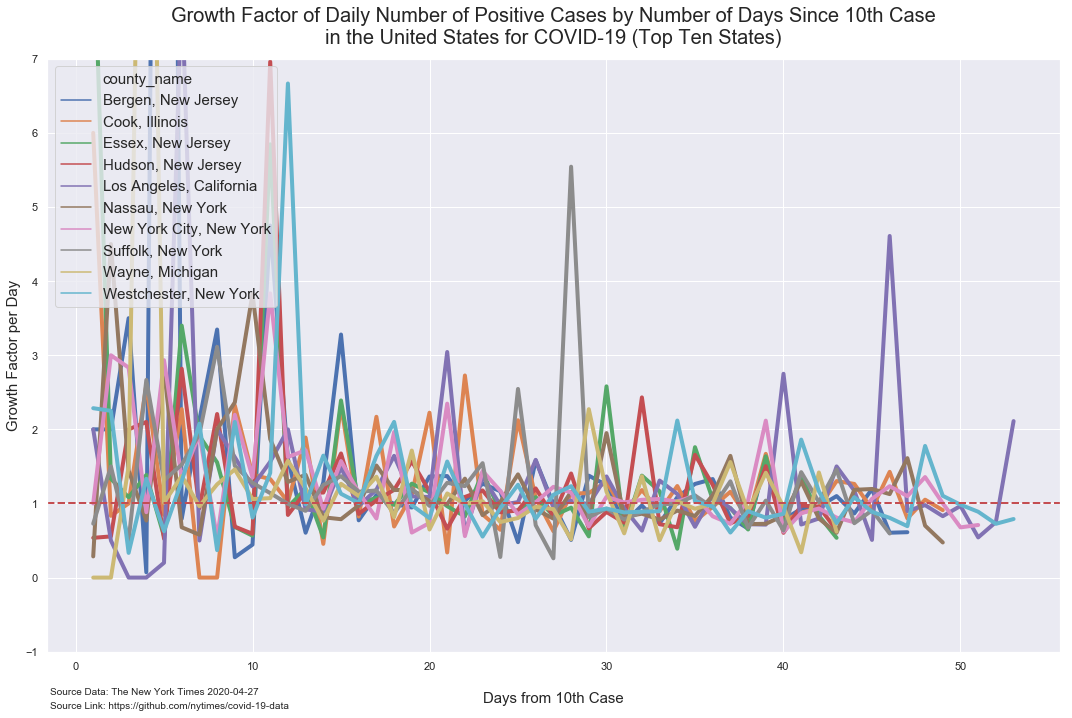

In [82]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="days_since_ten_case", y="growth_rate",
             hue="county_name", data=growth_rate , linewidth=4)

ax1.axhline(1, color='r', lw=2, linestyle='dashed')

ax1.xaxis.labelpad = 20

ax1.grid(True)
ax1.grid(axis='x', which='minor')
plt.ylim(-1, 7)

ax1.legend(loc='upper left', fontsize=15)
ax1.set_xlabel('Days from 10th Case', fontsize=15)
ax1.set_ylabel('Growth Factor per Day', fontsize=15)
plt.title('Growth Factor of Daily Number of Positive Cases by Number of Days Since 10th Case\nin the United States for COVID-19 (Top Ten States)', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/growth-factor-top-10-daily')

# Weekly Growth Rate

In [83]:
growth_rate_weekly = growth_rate.set_index('date').groupby('county_name').resample('W').agg({'days_since_ten_case': 
                                                                    np.max, 'growth_rate': np.mean})

In [84]:
growth_rate_weekly

days_since_ten_case  growth_rate
county_name           date                                        
Bergen, New Jersey    2020-03-15                    4     1.892857
                      2020-03-22                   11     5.819902
                      2020-03-29                   18     1.378264
                      2020-04-05                   25     1.089289
                      2020-04-12                   32     1.060000
...                                               ...          ...
Westchester, New York 2020-04-05                   31     1.013730
                      2020-04-12                   38     1.057008
                      2020-04-19                   45     1.057690
                      2020-04-26                   52     0.996841
                      2020-05-03                   53     0.790323

[80 rows x 2 columns]

In [85]:
growth_rate_weekly.reset_index(inplace=True)
growth_rate_weekly.rename(columns={'growth_rate': 'growth_rate_weekly_average'}, inplace=True)

In [86]:
growth_rate_weekly

county_name       date  days_since_ten_case  \
0      Bergen, New Jersey 2020-03-15                    4   
1      Bergen, New Jersey 2020-03-22                   11   
2      Bergen, New Jersey 2020-03-29                   18   
3      Bergen, New Jersey 2020-04-05                   25   
4      Bergen, New Jersey 2020-04-12                   32   
..                    ...        ...                  ...   
75  Westchester, New York 2020-04-05                   31   
76  Westchester, New York 2020-04-12                   38   
77  Westchester, New York 2020-04-19                   45   
78  Westchester, New York 2020-04-26                   52   
79  Westchester, New York 2020-05-03                   53   

    growth_rate_weekly_average  
0                     1.892857  
1                     5.819902  
2                     1.378264  
3                     1.089289  
4                     1.060000  
..                         ...  
75                    1.013730  
76                    1.057008  
77                    1.057690  
78                    0.996841  
79                    0.790323  

[80 rows x 4 columns]

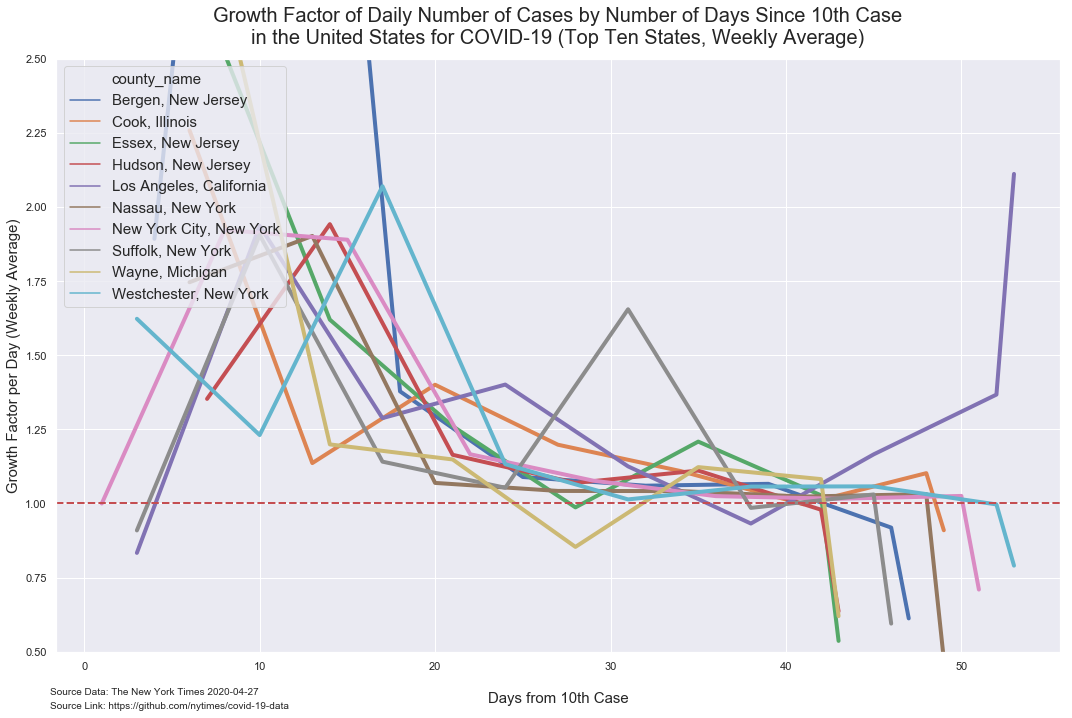

In [87]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="days_since_ten_case", y="growth_rate_weekly_average",
             hue="county_name", data=growth_rate_weekly, linewidth=4)

ax1.axhline(1, color='r', lw=2, linestyle='dashed')

ax1.xaxis.labelpad = 20

ax1.grid(True)
ax1.grid(axis='x', which='minor')
plt.ylim(0.5, 2.5)

ax1.legend(loc='upper left', fontsize=15)
ax1.set_xlabel('Days from 10th Case', fontsize=15)
ax1.set_ylabel('Growth Factor per Day (Weekly Average)', fontsize=15)
plt.title('Growth Factor of Daily Number of Cases by Number of Days Since 10th Case\nin the United States for COVID-19 (Top Ten States, Weekly Average)', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/growth-factor-top-10-weekly')

# Cumulative Number of Cases

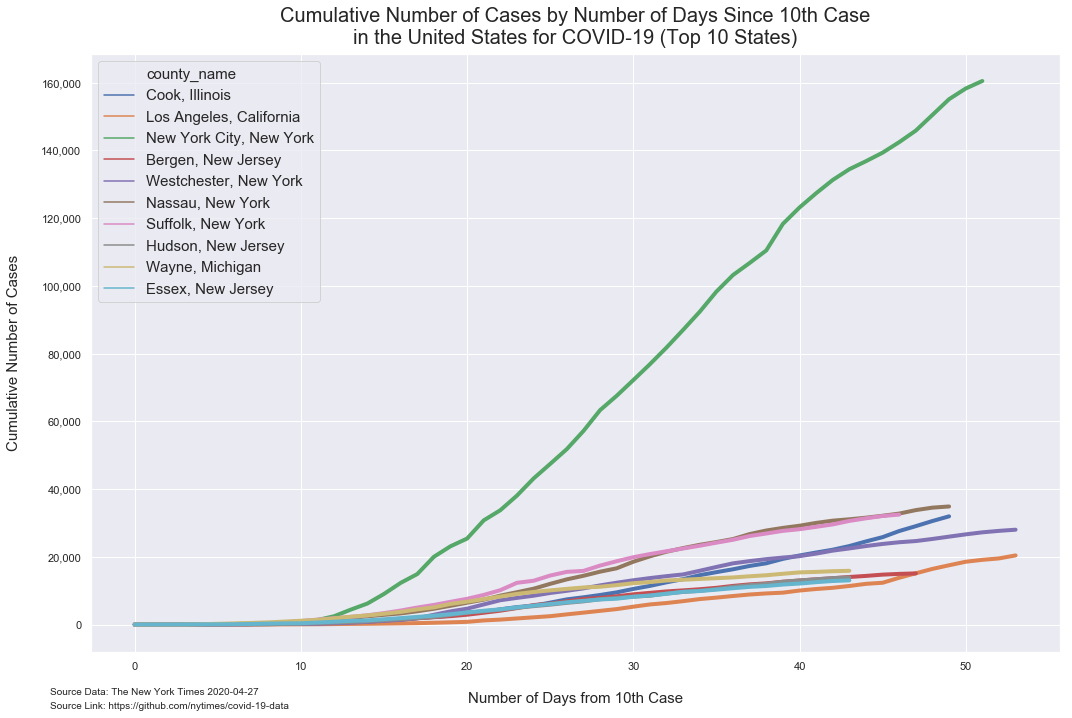

In [88]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="days_since_ten_case", y="cases",
             hue="county_name",
             data=county_ten_cases, linewidth=4)

ax1.xaxis.grid(True, which="major")
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax1.grid(True)
ax1.grid(axis='x', which='minor')
ax1.xaxis.labelpad = 20
ax1.yaxis.labelpad = 20

ax1.legend(fontsize=15)
ax1.set_xlabel('Number of Days from 10th Case', fontsize=15)
ax1.set_ylabel('Cumulative Number of Cases', fontsize=15)
plt.title('Cumulative Number of Cases by Number of Days Since 10th Case\nin the United States for COVID-19 (Top 10 States)', 
          pad = 10, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/county-timeseries-tenth-case')

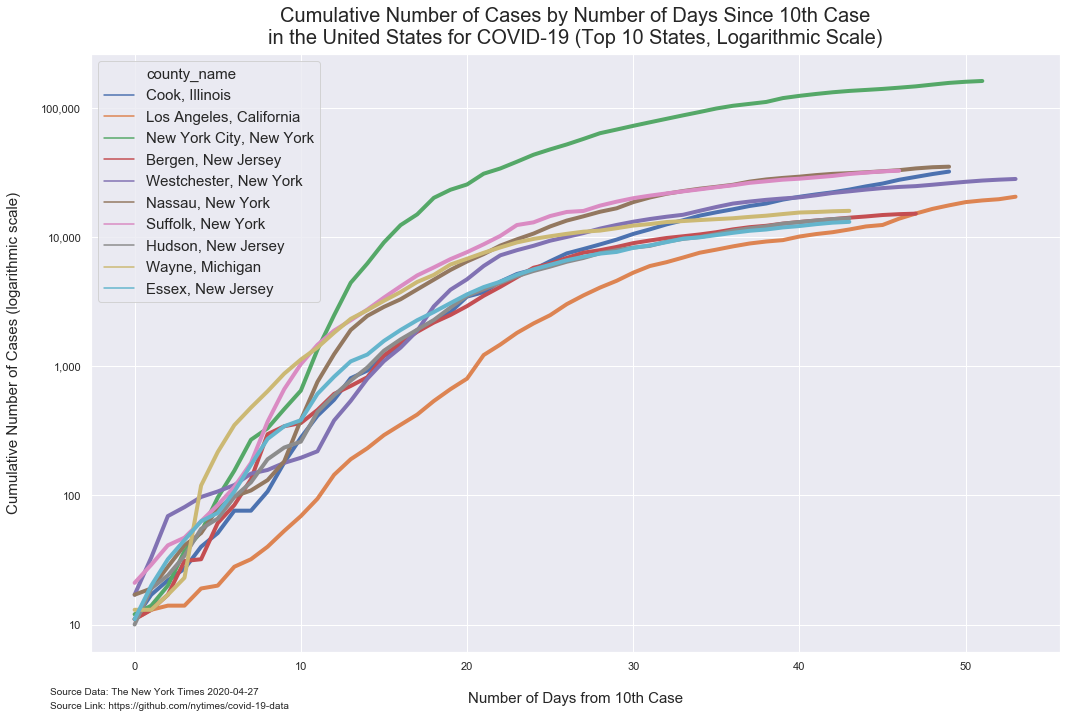

In [89]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="days_since_ten_case", y="cases",
             hue="county_name",
             data=county_ten_cases, linewidth=4)
    
ax1.set_yscale('log')

ax1.xaxis.grid(True, which="major")
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax1.grid(True)
ax1.grid(axis='x', which='minor')
ax1.xaxis.labelpad = 20
ax1.yaxis.labelpad = 20

ax1.legend(fontsize=15)
ax1.set_xlabel('Number of Days from 10th Case', fontsize=15)
ax1.set_ylabel('Cumulative Number of Cases (logarithmic scale)', fontsize=15)
plt.title('Cumulative Number of Cases by Number of Days Since 10th Case\nin the United States for COVID-19 (Top 10 States, Logarithmic Scale)', 
          pad = 10, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/county-timeseries-tenth-case-log')

# Cumulative Cases for All States

In [90]:
ten_cases_all_states = covid_19_counties_data.loc[covid_19_counties_data['cases'] >= 10]

In [91]:
ten_cases_all_states = ten_cases_all_states.sort_values(by=['date', 'cases'], 
                                ascending=[True, True], ).drop_duplicates(subset ="county_name", keep = 'first').reset_index(drop=True)

In [92]:
ten_cases_all_states = ten_cases_all_states[['county_name', 'date']]
ten_cases_all_states.rename(columns={'date': 'ten_cases_date'}, inplace=True)

In [93]:
ten_cases_all_states

county_name ten_cases_date
0           Douglas, Nebraska     2020-02-17
1                Bexar, Texas     2020-02-24
2          Solano, California     2020-02-26
3            King, Washington     2020-03-01
4     Santa Clara, California     2020-03-03
...                       ...            ...
1831       Le Flore, Oklahoma     2020-04-27
1832     Humphreys, Tennessee     2020-04-27
1833   Fayette, West Virginia     2020-04-27
1834     Salem city, Virginia     2020-04-27
1835   Jefferson, Mississippi     2020-04-27

[1836 rows x 2 columns]

In [94]:
ten_cases_all_states = covid_19_counties_data.merge(ten_cases_all_states, left_on='county_name', right_on='county_name')

In [95]:
ten_cases_all_states = ten_cases_all_states.loc[ten_cases_all_states['cases'] >= 10]

In [96]:
ten_cases_all_states

date       county       state     fips  cases  deaths  \
44    2020-03-05    Snohomish  Washington  53061.0     17       0   
45    2020-03-06    Snohomish  Washington  53061.0     18       0   
46    2020-03-07    Snohomish  Washington  53061.0     26       0   
47    2020-03-08    Snohomish  Washington  53061.0     36       0   
48    2020-03-09    Snohomish  Washington  53061.0     45       0   
...          ...          ...         ...      ...    ...     ...   
69842 2020-04-26         Cass    Illinois  17017.0     27       0   
69843 2020-04-27         Cass    Illinois  17017.0     25       0   
69847 2020-04-25  Mississippi    Missouri  29133.0     23       0   
69848 2020-04-26  Mississippi    Missouri  29133.0     23       0   
69849 2020-04-27  Mississippi    Missouri  29133.0     23       0   

                 county_name ten_cases_date  
44     Snohomish, Washington     2020-03-05  
45     Snohomish, Washington     2020-03-05  
46     Snohomish, Washington     2020-03-05  
47     Snohomish, Washington     2020-03-05  
48     Snohomish, Washington     2020-03-05  
...                      ...            ...  
69842         Cass, Illinois     2020-04-24  
69843         Cass, Illinois     2020-04-24  
69847  Mississippi, Missouri     2020-04-25  
69848  Mississippi, Missouri     2020-04-25  
69849  Mississippi, Missouri     2020-04-25  

[45738 rows x 8 columns]

In [97]:
ten_cases_all_states['days_from_10_cases'] = (ten_cases_all_states['date'] - 
                                              ten_cases_all_states['ten_cases_date']).dt.days

In [98]:
ten_cases_all_states

date       county       state     fips  cases  deaths  \
44    2020-03-05    Snohomish  Washington  53061.0     17       0   
45    2020-03-06    Snohomish  Washington  53061.0     18       0   
46    2020-03-07    Snohomish  Washington  53061.0     26       0   
47    2020-03-08    Snohomish  Washington  53061.0     36       0   
48    2020-03-09    Snohomish  Washington  53061.0     45       0   
...          ...          ...         ...      ...    ...     ...   
69842 2020-04-26         Cass    Illinois  17017.0     27       0   
69843 2020-04-27         Cass    Illinois  17017.0     25       0   
69847 2020-04-25  Mississippi    Missouri  29133.0     23       0   
69848 2020-04-26  Mississippi    Missouri  29133.0     23       0   
69849 2020-04-27  Mississippi    Missouri  29133.0     23       0   

                 county_name ten_cases_date  days_from_10_cases  
44     Snohomish, Washington     2020-03-05                   0  
45     Snohomish, Washington     2020-03-05                   1  
46     Snohomish, Washington     2020-03-05                   2  
47     Snohomish, Washington     2020-03-05                   3  
48     Snohomish, Washington     2020-03-05                   4  
...                      ...            ...                 ...  
69842         Cass, Illinois     2020-04-24                   2  
69843         Cass, Illinois     2020-04-24                   3  
69847  Mississippi, Missouri     2020-04-25                   0  
69848  Mississippi, Missouri     2020-04-25                   1  
69849  Mississippi, Missouri     2020-04-25                   2  

[45738 rows x 9 columns]

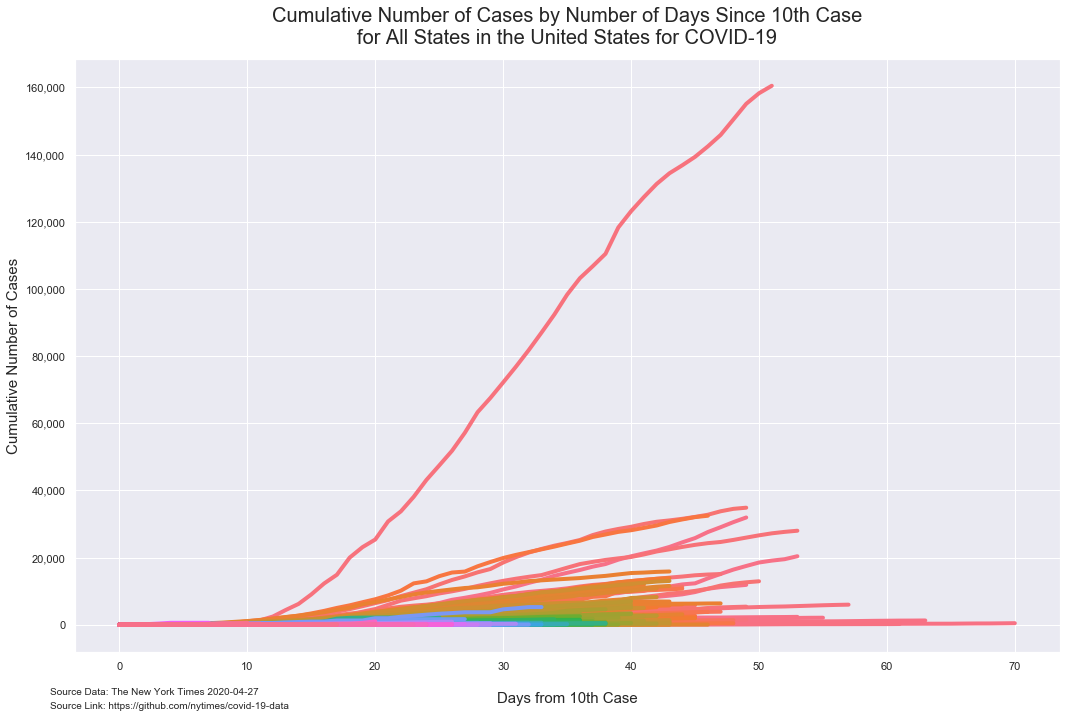

In [99]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="days_from_10_cases", y="cases",
             hue="county_name",
             data=ten_cases_all_states, linewidth=4)

ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.labelpad = 20

ax1.grid(True)
ax1.grid(axis='x', which='minor')

ax1.legend_.remove()
ax1.set_xlabel('Days from 10th Case', fontsize=15)
ax1.set_ylabel('Cumulative Number of Cases', fontsize=15)
plt.title('Cumulative Number of Cases by Number of Days Since 10th Case\nfor All States in the United States for COVID-19', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/10-cases-timeseries-all-counties')

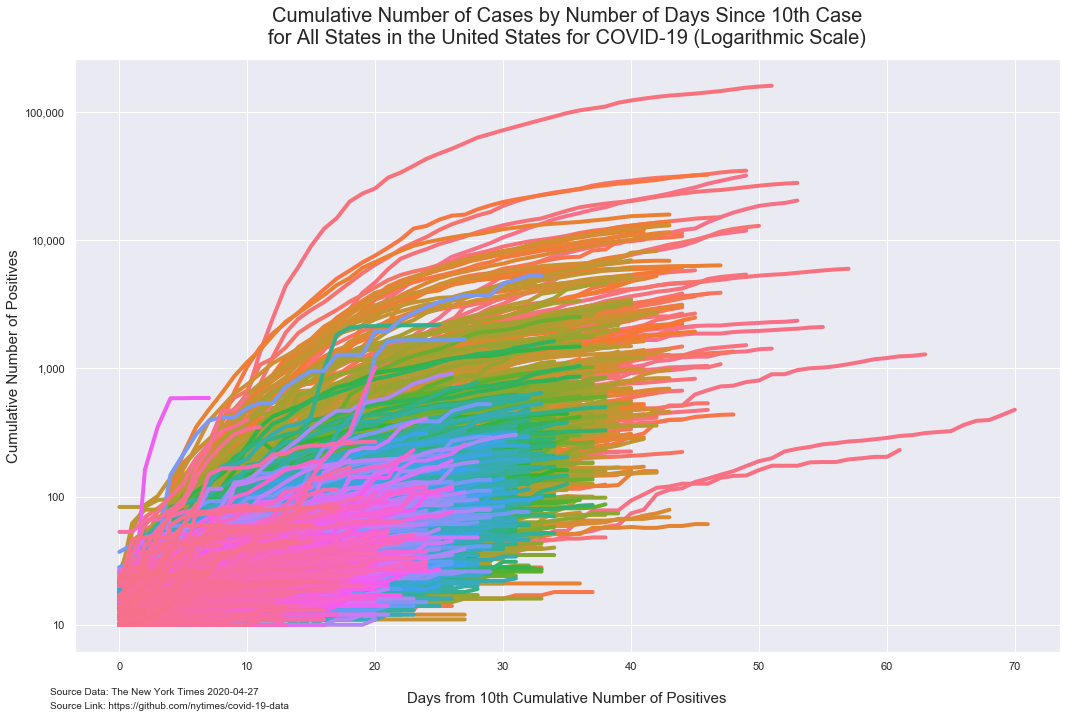

In [100]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="days_from_10_cases", y="cases",
             hue="county_name",
             data=ten_cases_all_states, linewidth=4)
ax1.set_yscale('log')

ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.labelpad = 20

ax1.grid(True)
ax1.grid(axis='x', which='minor')

ax1.legend_.remove()
ax1.set_xlabel('Days from 10th Cumulative Number of Positives', fontsize=15)
ax1.set_ylabel('Cumulative Number of Positives', fontsize=15)
plt.title('Cumulative Number of Cases by Number of Days Since 10th Case\nfor All States in the United States for COVID-19 (Logarithmic Scale)', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/10-cases-timeseries-all-counties-log')

# Trajectory Plots = daily number (log) vs. total number (log) 

## Daily

In [101]:
trajectory_plot = county_ten_cases.sort_values(by=['county_name', 'date','cases'], 
                                ascending=[True, True, True])

In [102]:
trajectory_plot[:50]

date  county         county_name  cases  daily_cases  deaths  \
253 2020-03-11  Bergen  Bergen, New Jersey     11          1.0       1   
254 2020-03-12  Bergen  Bergen, New Jersey     13          2.0       1   
255 2020-03-13  Bergen  Bergen, New Jersey     17          4.0       1   
256 2020-03-14  Bergen  Bergen, New Jersey     31         14.0       1   
257 2020-03-15  Bergen  Bergen, New Jersey     32          1.0       1   
258 2020-03-16  Bergen  Bergen, New Jersey     61         29.0       2   
259 2020-03-17  Bergen  Bergen, New Jersey     84         23.0       2   
260 2020-03-18  Bergen  Bergen, New Jersey    133         49.0       4   
261 2020-03-19  Bergen  Bergen, New Jersey    297        164.0       6   
262 2020-03-20  Bergen  Bergen, New Jersey    342         45.0       7   
263 2020-03-21  Bergen  Bergen, New Jersey    362         20.0       9   
264 2020-03-22  Bergen  Bergen, New Jersey    457         95.0      10   
265 2020-03-23  Bergen  Bergen, New Jersey    609        152.0      12   
266 2020-03-24  Bergen  Bergen, New Jersey    701         92.0      14   
267 2020-03-25  Bergen  Bergen, New Jersey    819        118.0      15   
268 2020-03-26  Bergen  Bergen, New Jersey   1206        387.0      21   
269 2020-03-27  Bergen  Bergen, New Jersey   1505        299.0      28   
270 2020-03-28  Bergen  Bergen, New Jersey   1838        333.0      35   
271 2020-03-29  Bergen  Bergen, New Jersey   2169        331.0      35   
272 2020-03-30  Bergen  Bergen, New Jersey   2482        313.0      41   
273 2020-03-31  Bergen  Bergen, New Jersey   2909        427.0      53   
274 2020-04-01  Bergen  Bergen, New Jersey   3494        585.0      75   
275 2020-04-02  Bergen  Bergen, New Jersey   4099        605.0     120   
276 2020-04-03  Bergen  Bergen, New Jersey   4866        767.0     132   
277 2020-04-04  Bergen  Bergen, New Jersey   5760        894.0     179   
278 2020-04-05  Bergen  Bergen, New Jersey   6187        427.0     189   
279 2020-04-06  Bergen  Bergen, New Jersey   6862        675.0     200   
280 2020-04-07  Bergen  Bergen, New Jersey   7533        671.0     263   
281 2020-04-08  Bergen  Bergen, New Jersey   7874        341.0     314   
282 2020-04-09  Bergen  Bergen, New Jersey   8343        469.0     345   
283 2020-04-10  Bergen  Bergen, New Jersey   8928        585.0     390   
284 2020-04-11  Bergen  Bergen, New Jersey   9362        434.0     435   
285 2020-04-12  Bergen  Bergen, New Jersey   9784        422.0     453   
286 2020-04-13  Bergen  Bergen, New Jersey  10092        308.0     482   
287 2020-04-14  Bergen  Bergen, New Jersey  10426        334.0     550   
288 2020-04-15  Bergen  Bergen, New Jersey  10848        422.0     608   
289 2020-04-16  Bergen  Bergen, New Jersey  11409        561.0     668   
290 2020-04-17  Bergen  Bergen, New Jersey  11863        454.0     714   
291 2020-04-18  Bergen  Bergen, New Jersey  12163        300.0     741   
292 2020-04-19  Bergen  Bergen, New Jersey  12639        476.0     767   
293 2020-04-20  Bergen  Bergen, New Jersey  13011        372.0     787   
294 2020-04-21  Bergen  Bergen, New Jersey  13356        345.0     835   
295 2020-04-22  Bergen  Bergen, New Jersey  13686        330.0     876   
296 2020-04-23  Bergen  Bergen, New Jersey  14049        363.0     907   
297 2020-04-24  Bergen  Bergen, New Jersey  14363        314.0     934   
298 2020-04-25  Bergen  Bergen, New Jersey  14738        375.0     954   
299 2020-04-26  Bergen  Bergen, New Jersey  14965        227.0     955   
300 2020-04-27  Bergen  Bergen, New Jersey  15104        139.0     960   
45  2020-03-09    Cook      Cook, Illinois     11          1.0       0   
46  2020-03-10    Cook      Cook, Illinois     17          6.0       0   

    date_ten_case  days_since_ten_case  
253    2020-03-11                    0  
254    2020-03-11                    1  
255    2020-03-11                    2  
256    2020-03-11                    3  
257    2020-03-11             

In [103]:
trajectory_plot.sort_values(by='daily_cases')

date         county              county_name   cases  daily_cases  \
517 2020-03-16          Wayne          Wayne, Michigan      13          0.0   
137 2020-03-08    Los Angeles  Los Angeles, California      14          0.0   
52  2020-03-16           Cook           Cook, Illinois      76          0.0   
467 2020-03-15         Hudson       Hudson, New Jersey      10          0.0   
139 2020-03-10    Los Angeles  Los Angeles, California      20          1.0   
..         ...            ...                      ...     ...          ...   
228 2020-04-10  New York City  New York City, New York   92384       5356.0   
215 2020-03-28  New York City  New York City, New York   30766       5367.0   
229 2020-04-11  New York City  New York City, New York   98308       5924.0   
222 2020-04-04  New York City  New York City, New York   63307       6147.0   
233 2020-04-15  New York City  New York City, New York  118302       7837.0   

     deaths date_ten_case  days_since_ten_case  
517       0    2020-03-15                    1  
137       0    2020-03-05                    3  
52        0    2020-03-09                    7  
467       0    2020-03-15                    0  
139       0    2020-03-05                    5  
..      ...           ...                  ...  
228    5663    2020-03-07                   34  
215     672    2020-03-07                   21  
229    6202    2020-03-07                   35  
222    2254    2020-03-07                   28  
233    8215    2020-03-07                   39  

[487 rows x 8 columns]

In [104]:
trajectory_plot['daily_cases'].loc[trajectory_plot.daily_cases == 0] = 1

/Users/geribauer/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


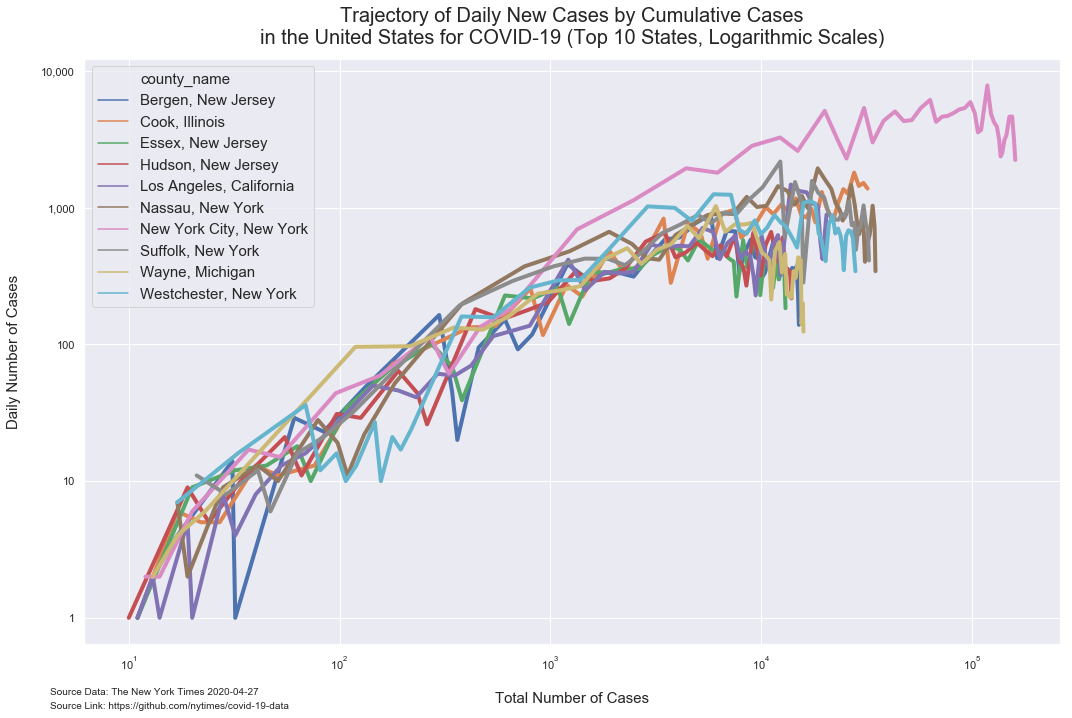

In [105]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="cases", y="daily_cases",
             hue="county_name",
             data=trajectory_plot, linewidth=4, ci=False)

ax1.set_yscale('log')
ax1.set_xscale('log')

ax1.xaxis.grid(True, which="major")
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax1.xaxis.labelpad = 20
ax1.yaxis.labelpad = 20

ax1.legend(fontsize=15)
ax1.set_xlabel('Total Number of Cases', fontsize=15)
ax1.set_ylabel('Daily Number of Cases', fontsize=15)
plt.title('Trajectory of Daily New Cases by Cumulative Cases\nin the United States for COVID-19 (Top 10 States, Logarithmic Scales)', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
#plt.savefig('figures/county-trajectory-daily-plot')

## Weekly

In [106]:
trajectory_plot_weekly = trajectory_plot[['county_name', 'date', 'cases', 'daily_cases']]

In [107]:
trajectory_plot_weekly.head()

county_name       date  cases  daily_cases
253  Bergen, New Jersey 2020-03-11     11          1.0
254  Bergen, New Jersey 2020-03-12     13          2.0
255  Bergen, New Jersey 2020-03-13     17          4.0
256  Bergen, New Jersey 2020-03-14     31         14.0
257  Bergen, New Jersey 2020-03-15     32          1.0

In [108]:
trajectory_plot_weekly = trajectory_plot.set_index('date').groupby('county_name').resample('W').agg({'cases': np.max, 
                                                                                               'daily_cases': np.mean})

In [109]:
trajectory_plot_weekly

cases  daily_cases
county_name           date                          
Bergen, New Jersey    2020-03-15     32     4.400000
                      2020-03-22    457    60.714286
                      2020-03-29   2169   244.571429
                      2020-04-05   6187   574.000000
                      2020-04-12   9784   513.857143
...                                 ...          ...
Westchester, New York 2020-04-05  13722   743.285714
                      2020-04-12  19313   798.714286
                      2020-04-19  23803   641.428571
                      2020-04-26  27664   551.571429
                      2020-05-03  28007   343.000000

[83 rows x 2 columns]

In [110]:
trajectory_plot_weekly.reset_index(inplace=True)

In [111]:
trajectory_plot_weekly.rename(columns={'daily_cases': 'daily_cases_weekly_average'}, inplace=True)

In [112]:
trajectory_plot_weekly

county_name       date  cases  daily_cases_weekly_average
0      Bergen, New Jersey 2020-03-15     32                    4.400000
1      Bergen, New Jersey 2020-03-22    457                   60.714286
2      Bergen, New Jersey 2020-03-29   2169                  244.571429
3      Bergen, New Jersey 2020-04-05   6187                  574.000000
4      Bergen, New Jersey 2020-04-12   9784                  513.857143
..                    ...        ...    ...                         ...
78  Westchester, New York 2020-04-05  13722                  743.285714
79  Westchester, New York 2020-04-12  19313                  798.714286
80  Westchester, New York 2020-04-19  23803                  641.428571
81  Westchester, New York 2020-04-26  27664                  551.571429
82  Westchester, New York 2020-05-03  28007                  343.000000

[83 rows x 4 columns]

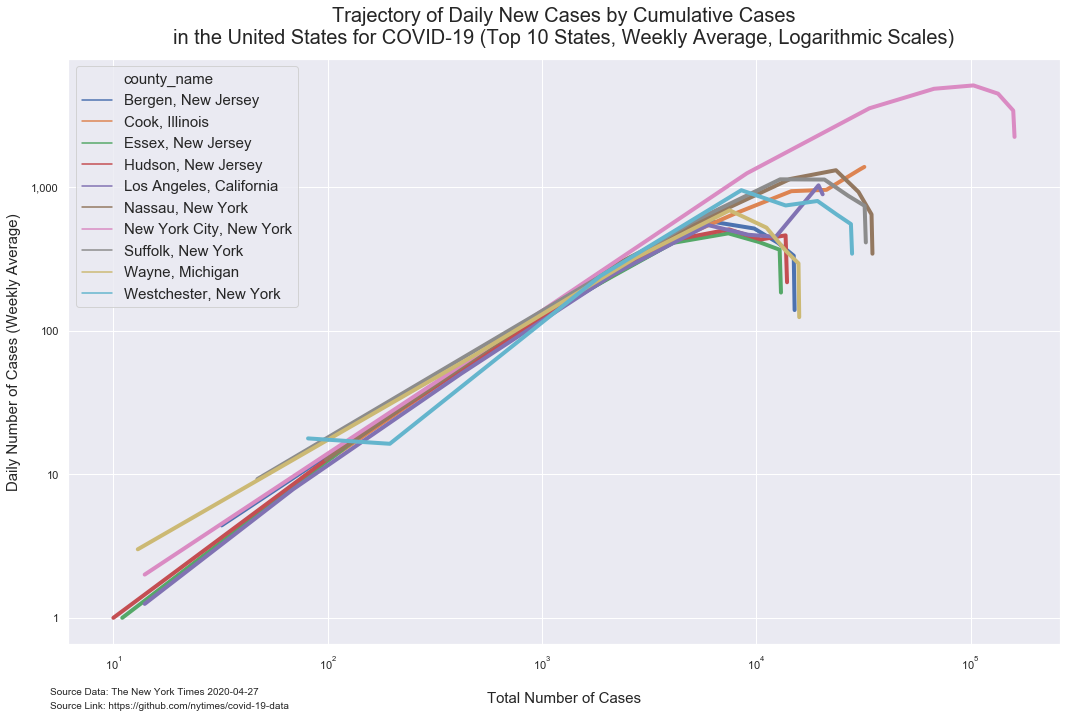

In [113]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="cases", y="daily_cases_weekly_average",
             hue="county_name",
             data=trajectory_plot_weekly, linewidth=4)

ax1.set_yscale('log')
ax1.set_xscale('log')

ax1.xaxis.grid(True, which="major")
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax1.xaxis.labelpad = 20
ax1.yaxis.labelpad = 10

ax1.legend(fontsize=15)
ax1.set_xlabel('Total Number of Cases', fontsize=15)
ax1.set_ylabel('Daily Number of Cases (Weekly Average)', fontsize=15)
plt.title('Trajectory of Daily New Cases by Cumulative Cases\nin the United States for COVID-19 (Top 10 States, Weekly Average, Logarithmic Scales)', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/county-trajectory-weekly-plot')

In [114]:
trajectory_plot_weekly_scatter = trajectory_plot_weekly.sort_values(by=['date', 'cases'], 
                                              ascending=[False, False]).drop_duplicates(subset ="county_name", 
                                                                                        keep = 'first').reset_index(drop=True)

In [115]:
trajectory_plot_weekly_scatter

county_name       date   cases  daily_cases_weekly_average
0  New York City, New York 2020-05-03  160499                      2231.0
1         Nassau, New York 2020-05-03   34865                       343.0
2        Suffolk, New York 2020-05-03   32470                       411.0
3           Cook, Illinois 2020-05-03   31953                      1379.0
4    Westchester, New York 2020-05-03   28007                       343.0
5  Los Angeles, California 2020-05-03   20417                       889.0
6          Wayne, Michigan 2020-05-03   15872                       124.0
7       Bergen, New Jersey 2020-05-03   15104                       139.0
8       Hudson, New Jersey 2020-05-03   13925                       217.0
9        Essex, New Jersey 2020-05-03   13047                       184.0

In [116]:
len(trajectory_plot_weekly_scatter)

10

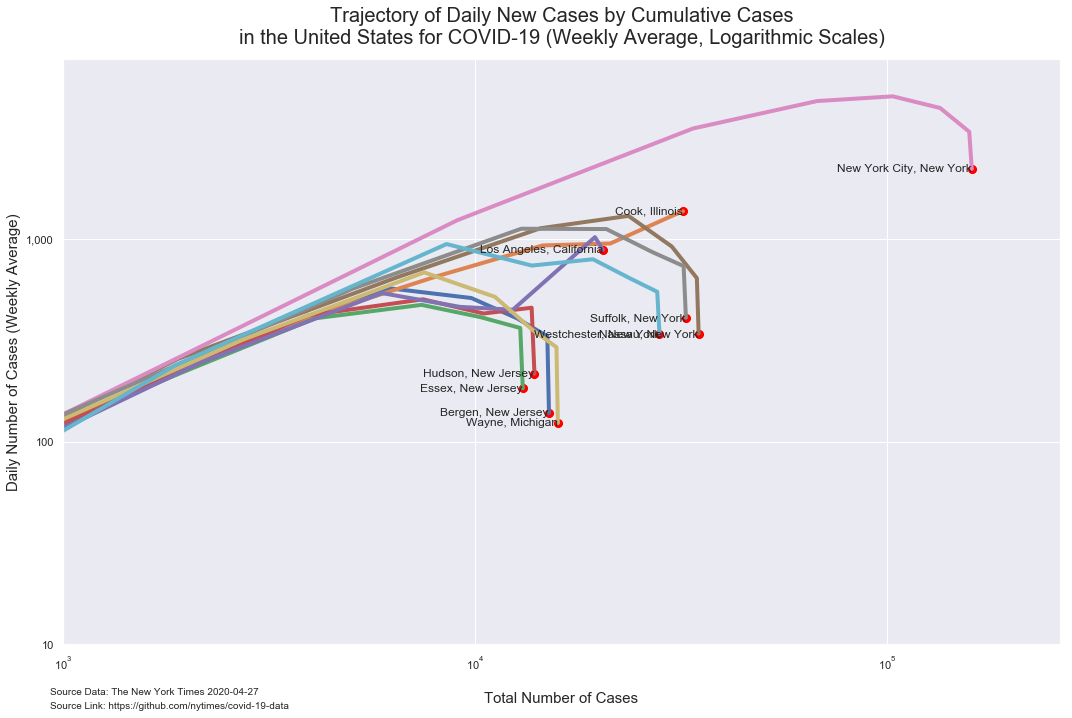

In [117]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="cases", y="daily_cases_weekly_average",
             hue="county_name",
             data=trajectory_plot_weekly, linewidth=4)

sns.scatterplot(x="cases", y="daily_cases_weekly_average", 
             data=trajectory_plot_weekly_scatter, s=100, ax=ax1, color='red')


x = trajectory_plot_weekly_scatter.daily_cases_weekly_average
z = trajectory_plot_weekly_scatter.cases
n = trajectory_plot_weekly_scatter.county_name
for i, label in enumerate(n):
    ax1.annotate(label, (z[i], x[i]), fontsize=12,
                 horizontalalignment='right', va='center', clip_on=True)
                
ax1.set_yscale('log')
ax1.set_xscale('log')

ax1.xaxis.grid(True, which="major")
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax1.xaxis.labelpad = 20
ax1.yaxis.labelpad = 5
plt.xlim(1000)
plt.ylim(10)

ax1.legend_.remove()
ax1.set_xlabel('Total Number of Cases', fontsize=15)
ax1.set_ylabel('Daily Number of Cases (Weekly Average)', fontsize=15)
plt.title('Trajectory of Daily New Cases by Cumulative Cases\nin the United States for COVID-19 (Weekly Average, Logarithmic Scales)', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/all-counties-trajectory-weekly-plot-labels')

# Trajectory for All Counties

In [118]:
trajectory_all_counties = covid_19_counties_data.sort_values(by=['county_name', 'date','cases'], 
                                ascending=[True, True, True])

In [119]:
trajectory_all_counties

date     county           state     fips  cases  deaths  \
5000  2020-03-19  Abbeville  South Carolina  45001.0      1       0   
5873  2020-03-20  Abbeville  South Carolina  45001.0      1       0   
6877  2020-03-21  Abbeville  South Carolina  45001.0      1       0   
7997  2020-03-22  Abbeville  South Carolina  45001.0      1       0   
9209  2020-03-23  Abbeville  South Carolina  45001.0      1       0   
...          ...        ...             ...      ...    ...     ...   
83801 2020-04-23     Zavala           Texas  48507.0      1       0   
86609 2020-04-24     Zavala           Texas  48507.0      1       0   
89427 2020-04-25     Zavala           Texas  48507.0      1       0   
92245 2020-04-26     Zavala           Texas  48507.0      1       0   
95074 2020-04-27     Zavala           Texas  48507.0      1       0   

                     county_name  
5000   Abbeville, South Carolina  
5873   Abbeville, South Carolina  
6877   Abbeville, South Carolina  
7997   Abbeville, South Carolina  
9209   Abbeville, South Carolina  
...                          ...  
83801              Zavala, Texas  
86609              Zavala, Texas  
89427              Zavala, Texas  
92245              Zavala, Texas  
95074              Zavala, Texas  

[94367 rows x 7 columns]

In [120]:
trajectory_all_counties['daily_cases'] = trajectory_all_counties['cases'].diff()

In [121]:
trajectory_all_counties[150:200]

date county  state     fips  cases  deaths  county_name  \
62492 2020-04-16    Ada  Idaho  16001.0    548       9   Ada, Idaho   
65226 2020-04-17    Ada  Idaho  16001.0    567       9   Ada, Idaho   
67976 2020-04-18    Ada  Idaho  16001.0    570      10   Ada, Idaho   
70738 2020-04-19    Ada  Idaho  16001.0    570      10   Ada, Idaho   
73508 2020-04-20    Ada  Idaho  16001.0    587      12   Ada, Idaho   
76285 2020-04-21    Ada  Idaho  16001.0    589      12   Ada, Idaho   
79068 2020-04-22    Ada  Idaho  16001.0    597      14   Ada, Idaho   
81864 2020-04-23    Ada  Idaho  16001.0    601      14   Ada, Idaho   
84665 2020-04-24    Ada  Idaho  16001.0    610      14   Ada, Idaho   
87476 2020-04-25    Ada  Idaho  16001.0    615      15   Ada, Idaho   
90295 2020-04-26    Ada  Idaho  16001.0    615      15   Ada, Idaho   
93115 2020-04-27    Ada  Idaho  16001.0    621      15   Ada, Idaho   
3388  2020-03-17  Adair   Iowa  19001.0      1       0  Adair, Iowa   
3962  2020-03-18  Adair   Iowa  19001.0      1       0  Adair, Iowa   
4641  2020-03-19  Adair   Iowa  19001.0      1       0  Adair, Iowa   
5452  2020-03-20  Adair   Iowa  19001.0      1       0  Adair, Iowa   
6393  2020-03-21  Adair   Iowa  19001.0      1       0  Adair, Iowa   
7453  2020-03-22  Adair   Iowa  19001.0      1       0  Adair, Iowa   
8611  2020-03-23  Adair   Iowa  19001.0      1       0  Adair, Iowa   
9891  2020-03-24  Adair   Iowa  19001.0      1       0  Adair, Iowa   
11291 2020-03-25  Adair   Iowa  19001.0      1       0  Adair, Iowa   
12859 2020-03-26  Adair   Iowa  19001.0      1       0  Adair, Iowa   
14556 2020-03-27  Adair   Iowa  19001.0      1       0  Adair, Iowa   
16368 2020-03-28  Adair   Iowa  19001.0      1       0  Adair, Iowa   
18286 2020-03-29  Adair   Iowa  19001.0      1       0  Adair, Iowa   
20305 2020-03-30  Adair   Iowa  19001.0      1       0  Adair, Iowa   
22416 2020-03-31  Adair   Iowa  19001.0      1       0  Adair, Iowa   
24601 2020-04-01  Adair   Iowa  19001.0      1       0  Adair, Iowa   
26846 2020-04-02  Adair   Iowa  19001.0      1       0  Adair, Iowa   
29152 2020-04-03  Adair   Iowa  19001.0      1       0  Adair, Iowa   
31522 2020-04-04  Adair   Iowa  19001.0      1       0  Adair, Iowa   
33934 2020-04-05  Adair   Iowa  19001.0      1       0  Adair, Iowa   
36391 2020-04-06  Adair   Iowa  19001.0      1       0  Adair, Iowa   
38888 2020-04-07  Adair   Iowa  19001.0      1       0  Adair, Iowa   
41432 2020-04-08  Adair   Iowa  19001.0      1       0  Adair, Iowa   
44001 2020-04-09  Adair   Iowa  19001.0      1       0  Adair, Iowa   
46603 2020-04-10  Adair   Iowa  19001.0      1       0  Adair, Iowa   
49235 2020-04-11  Adair   Iowa  19001.0      1       0  Adair, Iowa   
51899 2020-04-12  Adair   Iowa  19001.0      1       0  Adair, Iowa   
54580 2020-04-13  Adair   Iowa  19001.0      1       0  Adair, Iowa   
57274 2020-04-14  Adair   Iowa  19001.0      1       0  Adair, Iowa   
59982 2020-04-15  Adair   Iowa  19001.0      1       0  Adair, Iowa   
62707 2020-04-16  Adair   Iowa  19001.0      1       0  Adair, Iowa   
65443 2020-04-17  Adair   Iowa  19001.0      1       0  Adair, Iowa   
68194 2020-04-18  Adair   Iowa  19001.0      1       0  Adair, Iowa   
70956 2020-04-19  Adair   Iowa  19001.0      1       0  Adair, Iowa   
73728 2020-04-20  Adair   Iowa  19001.0      1       0  Adair, Iowa   
76506 2020-04-21  Adair   Iowa  19001.0      1       0  Adair, Iowa   
79289 2020-04-22  Adair   Iowa  19001.0      1       0  Adair, Iowa   
82085 2020-04-23  Adair   Iowa  19001.0      1       0  Adair, Iowa   

       daily_cases  
62492          8.0  
65226         19.0  
67976          3.0  
70738          0.0  
73508         17.0  
76285          2.0  
79068          8.0  
81864          4.0  
84665          9.0  
87476          5.0  
90295          0.0  
93115          6.0  
3388        -620.0  
3962           0.0  
4641           0.0  
5452           0.0  
6393           0.0  
7453        

In [122]:
trajectory_all_counties['daily_cases'].loc[trajectory_all_counties.daily_cases < 0] = trajectory_all_counties.cases
trajectory_all_counties['daily_cases'].loc[trajectory_all_counties.daily_cases.isnull()] = trajectory_all_counties.cases

In [123]:
trajectory_all_counties[:50]

date     county           state     fips  cases  deaths  \
5000  2020-03-19  Abbeville  South Carolina  45001.0      1       0   
5873  2020-03-20  Abbeville  South Carolina  45001.0      1       0   
6877  2020-03-21  Abbeville  South Carolina  45001.0      1       0   
7997  2020-03-22  Abbeville  South Carolina  45001.0      1       0   
9209  2020-03-23  Abbeville  South Carolina  45001.0      1       0   
10539 2020-03-24  Abbeville  South Carolina  45001.0      1       0   
12015 2020-03-25  Abbeville  South Carolina  45001.0      3       0   
13647 2020-03-26  Abbeville  South Carolina  45001.0      4       0   
15404 2020-03-27  Abbeville  South Carolina  45001.0      4       0   
17268 2020-03-28  Abbeville  South Carolina  45001.0      4       0   
19222 2020-03-29  Abbeville  South Carolina  45001.0      4       0   
21283 2020-03-30  Abbeville  South Carolina  45001.0      3       0   
23435 2020-03-31  Abbeville  South Carolina  45001.0      4       0   
25642 2020-04-01  Abbeville  South Carolina  45001.0      4       0   
27915 2020-04-02  Abbeville  South Carolina  45001.0      6       0   
30250 2020-04-03  Abbeville  South Carolina  45001.0      6       0   
32643 2020-04-04  Abbeville  South Carolina  45001.0      6       0   
35082 2020-04-05  Abbeville  South Carolina  45001.0      6       0   
37560 2020-04-06  Abbeville  South Carolina  45001.0      6       0   
40080 2020-04-07  Abbeville  South Carolina  45001.0      5       0   
42636 2020-04-08  Abbeville  South Carolina  45001.0      6       0   
45216 2020-04-09  Abbeville  South Carolina  45001.0      7       0   
47832 2020-04-10  Abbeville  South Carolina  45001.0      7       0   
50487 2020-04-11  Abbeville  South Carolina  45001.0      9       0   
53160 2020-04-12  Abbeville  South Carolina  45001.0      9       0   
55847 2020-04-13  Abbeville  South Carolina  45001.0      9       0   
58550 2020-04-14  Abbeville  South Carolina  45001.0      9       0   
61268 2020-04-15  Abbeville  South Carolina  45001.0     10       0   
63996 2020-04-16  Abbeville  South Carolina  45001.0     10       0   
66744 2020-04-17  Abbeville  South Carolina  45001.0     10       0   
69502 2020-04-18  Abbeville  South Carolina  45001.0     15       0   
72270 2020-04-19  Abbeville  South Carolina  45001.0     17       0   
75047 2020-04-20  Abbeville  South Carolina  45001.0     17       0   
77829 2020-04-21  Abbeville  South Carolina  45001.0     18       0   
80620 2020-04-22  Abbeville  South Carolina  45001.0     22       0   
83421 2020-04-23  Abbeville  South Carolina  45001.0     23       0   
86226 2020-04-24  Abbeville  South Carolina  45001.0     24       0   
89043 2020-04-25  Abbeville  South Carolina  45001.0     24       0   
91860 2020-04-26  Abbeville  South Carolina  45001.0     27       0   
94687 2020-04-27  Abbeville  South Carolina  45001.0     29       0   
7518  2020-03-22     Acadia       Louisiana  22001.0      1       0   
8681  2020-03-23     Acadia       Louisiana  22001.0      1       0   
9973  2020-03-24     Acadia       Louisiana  22001.0      2       0   
11381 2020-03-25     Acadia       Louisiana  22001.0      2       0   
12963 2020-03-26     Acadia       Louisiana  22001.0      3       0   
14680 2020-03-27     Acadia       Louisiana  22001.0      8       1   
16507 2020-03-28     Acadia       Louisiana  22001.0      9       1   
18432 2020-03-29     Acadia       Louisiana  22001.0      9       1   
20461 2020-03-30     Acadia       Louisiana  22001.0     11       1   
22585 2020-03-31     Acadia       Louisiana  22001.0     39       1   

                     county_name  daily_cases  
5000   Abbeville, South Carolina          1.0  
5873   Abbeville, South Carolina          0.0  
6877   Abbeville, South Carolina          0.0  
7997   Abbeville, South Carolina          0.0  
9209   Abbeville, South Carolina          0.0  
10539  Abbeville, South Carolina          0.0  
12015  Abbeville, South Carolina          2.0  
13647 

In [124]:
trajectory_all_counties = trajectory_all_counties.set_index('date').groupby('county_name').resample('W').agg({'cases': np.max, 
                                                                                                    'daily_cases': np.mean})
trajectory_all_counties.reset_index(inplace=True)
trajectory_all_counties.rename(columns={'daily_cases': 'daily_cases_week_avg'}, inplace=True)

In [125]:
trajectory_all_counties.head()

county_name       date  cases  daily_cases_week_avg
0  Abbeville, South Carolina 2020-03-22    1.0              0.250000
1  Abbeville, South Carolina 2020-03-29    4.0              0.428571
2  Abbeville, South Carolina 2020-04-05    6.0              0.857143
3  Abbeville, South Carolina 2020-04-12    9.0              1.285714
4  Abbeville, South Carolina 2020-04-19   17.0              1.142857

In [126]:
temp_fill_zeros = trajectory_all_counties.sort_values(by=['county_name', 'date','cases'], 
                                                 ascending=[True, True, True])

temp_fill_zeros['cases'].loc[temp_fill_zeros.cases < 1] = 1
temp_fill_zeros['daily_cases_week_avg'].loc[temp_fill_zeros.daily_cases_week_avg < 1] = 1

temp_fill_zeros

county_name       date  cases  daily_cases_week_avg
0      Abbeville, South Carolina 2020-03-22    1.0              1.000000
1      Abbeville, South Carolina 2020-03-29    4.0              1.000000
2      Abbeville, South Carolina 2020-04-05    6.0              1.000000
3      Abbeville, South Carolina 2020-04-12    9.0              1.285714
4      Abbeville, South Carolina 2020-04-19   17.0              1.142857
...                          ...        ...    ...                   ...
17138              Zapata, Texas 2020-04-26    7.0              1.000000
17139              Zapata, Texas 2020-05-03    7.0              1.000000
17140              Zavala, Texas 2020-04-19    1.0              1.000000
17141              Zavala, Texas 2020-04-26    1.0              1.000000
17142              Zavala, Texas 2020-05-03    1.0              1.000000

[17143 rows x 4 columns]

In [127]:
temp_fill_zeros.loc[temp_fill_zeros.cases.isnull() == True]

county_name       date  cases  daily_cases_week_avg
1025          Benzie, Michigan 2020-04-12    NaN                   NaN
2384           Cedar, Nebraska 2020-04-26    NaN                   NaN
4158        Decatur, Tennessee 2020-04-05    NaN                   NaN
7408   Jackson, North Carolina 2020-04-12    NaN                   NaN
9729          Marion, Missouri 2020-04-12    NaN                   NaN
13045          Rhea, Tennessee 2020-04-12    NaN                   NaN
16243        Washita, Oklahoma 2020-04-12    NaN                   NaN
16244        Washita, Oklahoma 2020-04-19    NaN                   NaN
17058            Yoakum, Texas 2020-04-12    NaN                   NaN

In [128]:
temp_fill_zeros.dropna()

county_name       date  cases  daily_cases_week_avg
0      Abbeville, South Carolina 2020-03-22    1.0              1.000000
1      Abbeville, South Carolina 2020-03-29    4.0              1.000000
2      Abbeville, South Carolina 2020-04-05    6.0              1.000000
3      Abbeville, South Carolina 2020-04-12    9.0              1.285714
4      Abbeville, South Carolina 2020-04-19   17.0              1.142857
...                          ...        ...    ...                   ...
17138              Zapata, Texas 2020-04-26    7.0              1.000000
17139              Zapata, Texas 2020-05-03    7.0              1.000000
17140              Zavala, Texas 2020-04-19    1.0              1.000000
17141              Zavala, Texas 2020-04-26    1.0              1.000000
17142              Zavala, Texas 2020-05-03    1.0              1.000000

[17134 rows x 4 columns]

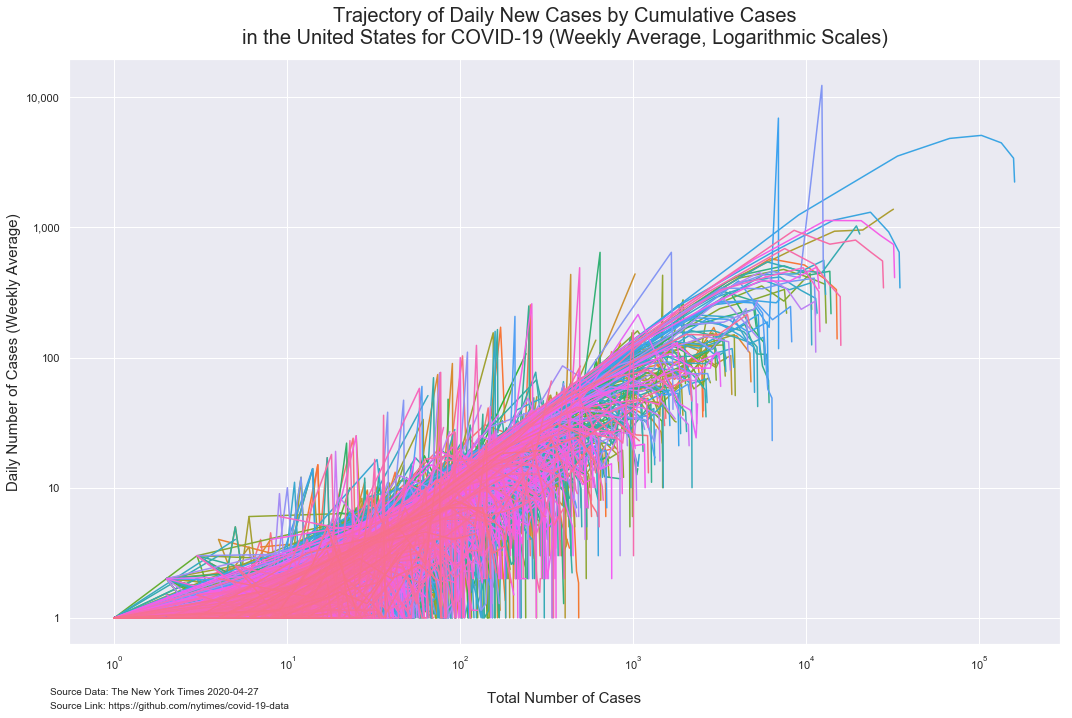

In [129]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="cases", y="daily_cases_week_avg",
             hue="county_name",
             data=temp_fill_zeros, ci=False)
                
ax1.set_yscale('log')
ax1.set_xscale('log')

ax1.xaxis.grid(True, which="major")
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax1.xaxis.labelpad = 20
ax1.yaxis.labelpad = 5

ax1.legend_.remove()
ax1.set_xlabel('Total Number of Cases', fontsize=15)
ax1.set_ylabel('Daily Number of Cases (Weekly Average)', fontsize=15)
plt.title('Trajectory of Daily New Cases by Cumulative Cases\nin the United States for COVID-19 (Weekly Average, Logarithmic Scales)', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/all-counties-trajectory-weekly-plot')

# Timeseries for USA

In [130]:
g = covid_19_counties_data.groupby('date')['cases'].sum().reset_index()

g.set_index('date', drop=False, inplace=True)

g.index = pd.to_datetime(g.index, infer_datetime_format=True)

In [131]:
g.index.dtype

dtype('<M8[ns]')

In [132]:
g.head()

date  cases
date                        
2020-01-21 2020-01-21      1
2020-01-22 2020-01-22      1
2020-01-23 2020-01-23      1
2020-01-24 2020-01-24      2
2020-01-25 2020-01-25      3

In [133]:
g.tail()

date   cases
date                         
2020-04-23 2020-04-23  859915
2020-04-24 2020-04-24  897163
2020-04-25 2020-04-25  930907
2020-04-26 2020-04-26  957125
2020-04-27 2020-04-27  979266

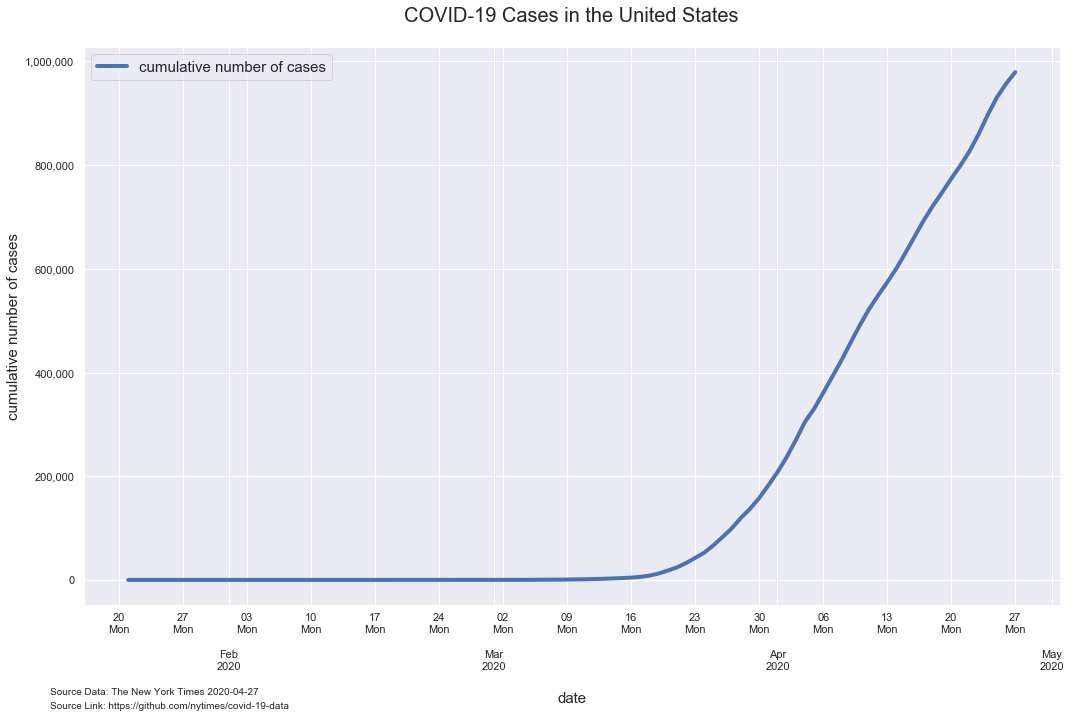

In [134]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

ax1.plot(g['cases'], linewidth=4)

ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0), interval=1))
ax1.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax1.xaxis.grid(True, which="major")
ax1.xaxis.set_major_locator(dates.MonthLocator())
ax1.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))
ax1.set_xlabel('date', fontsize=15, labelpad = 20)
ax1.set_ylabel('cumulative number of cases', fontsize=15)

ax1.grid(True)
ax1.grid(which='minor')

ax1.legend(['cumulative number of cases'], loc=2, fontsize=15)
plt.title('COVID-19 Cases in the United States', pad = 25, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/counties-linear')

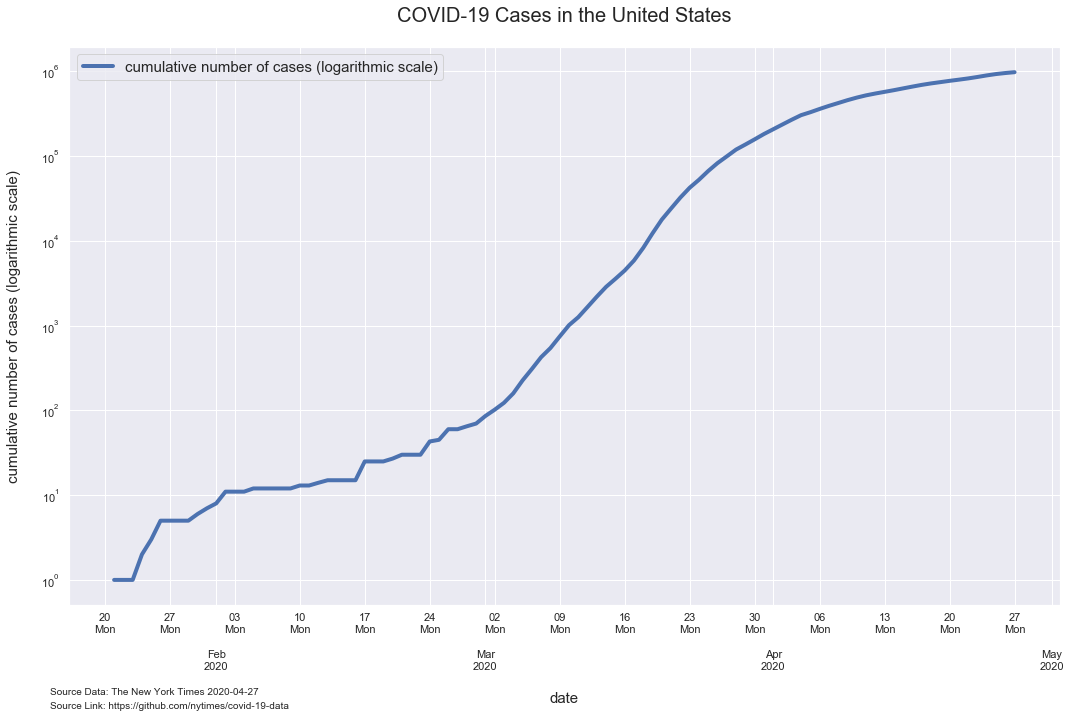

In [135]:
fig, ax2 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

ax2.plot(g['cases'], linewidth=4)

ax2.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0), interval=1))
ax2.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax2.xaxis.grid(True, which="major")
ax2.xaxis.set_major_locator(dates.MonthLocator())
ax2.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax2.set_xlabel('date', fontsize=15, labelpad = 20)
ax2.set_ylabel('cumulative number of cases (logarithmic scale)', fontsize=15, labelpad = 20)

ax2.grid(True)
ax2.grid(which='minor', axis='x')

ax2.legend(['cumulative number of cases (logarithmic scale)'], loc=0, fontsize=15)
plt.title('COVID-19 Cases in the United States', pad = 25, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

ax2.set_yscale('log')
plt.tight_layout()
plt.savefig('figures/counties-log')

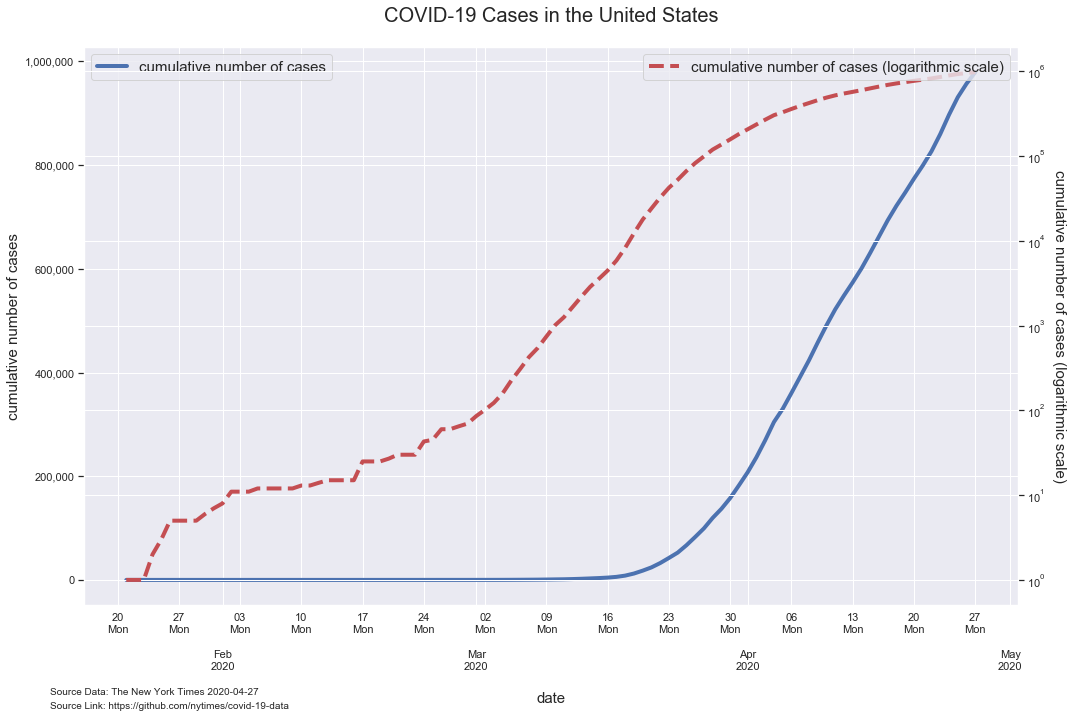

In [136]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

# Plot 1
ax1.plot(g['cases'], linewidth=4)

# Plot 2
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(g['cases'], linewidth=4, color='r', linestyle='dashed')

ax1.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0),interval=1))
ax1.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax1.xaxis.grid(True, which="major")
ax1.xaxis.set_major_locator(dates.MonthLocator())
ax1.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))
ax2.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0), interval=1))

ax1.set_ylabel('cumulative number of cases', fontsize=15)
ax1.set_xlabel('date', fontsize=15, labelpad = 20)
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.set_ylabel('cumulative number of cases (logarithmic scale)', fontsize=15, rotation = 270, labelpad = 20)
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.get_yaxis().set_visible(True)
ax2.set_yscale('log')

ax1.grid(True)
ax1.grid(which='minor')
ax2.tick_params(axis='both', which='minor', length=0)
plt.setp(ax2.get_yticklabels(), visible=True)

ax1.legend(['cumulative number of cases'], loc=2, fontsize=15)
ax2.legend(['cumulative number of cases (logarithmic scale)'], loc=1, fontsize=15)
plt.title('COVID-19 Cases in the United States', pad = 25, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/counties-timeseries-overlay')

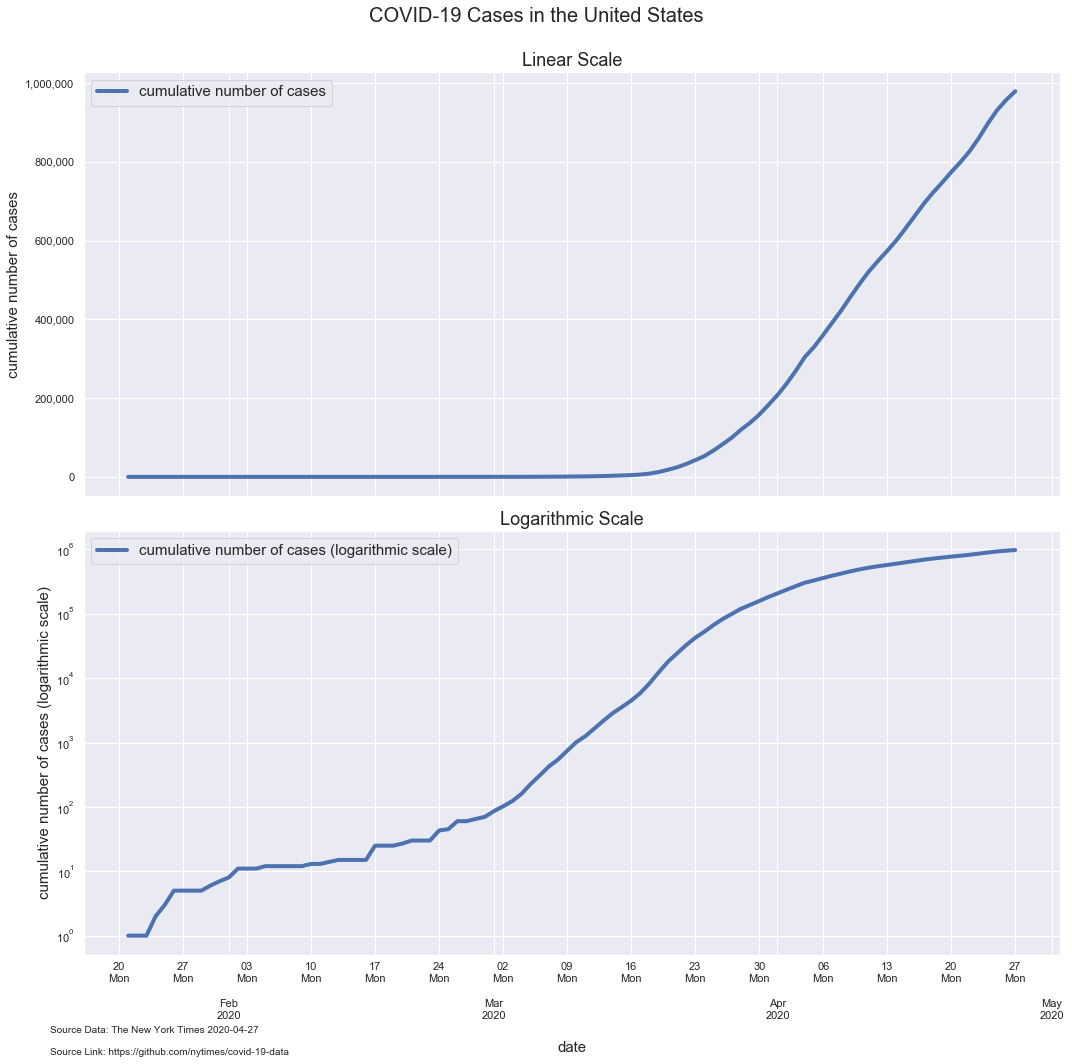

In [137]:
fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True, figsize=(15,15))
fig.suptitle('COVID-19 Cases in the United States', fontsize=20)
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

# Plot 1
ax1.plot(g['cases'], linewidth=4)
ax1.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0), interval=1))
ax1.set_ylabel('cumulative number of cases', fontsize=15)
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax1.xaxis.grid(True, which="major")
ax1.xaxis.set_major_locator(dates.MonthLocator())
ax1.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))

# Formatting Grid
ax1.grid(True)
ax1.grid(which='minor')

# Plot 2
ax2.plot(g['cases'], linewidth=4)
ax2.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0), interval=1))
ax2.set_ylabel('cumulative number of cases (logarithmic scale)', fontsize=15)
ax2.set_xlabel('date', fontsize=15, labelpad = 20)
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax2.xaxis.grid(True, which="major")
ax2.xaxis.set_major_locator(dates.MonthLocator())
ax2.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))

# Formatting Grid
ax2.grid(True)
ax2.grid(which='minor', axis='x')

# Formatting Figure
ax1.legend(['cumulative number of cases'], loc=2, fontsize=15)
ax2.legend(['cumulative number of cases (logarithmic scale)'], loc=2, fontsize=15)
ax1.set_title('Linear Scale', fontsize=18)
ax2.set_title('Logarithmic Scale', fontsize=18)
ax2.set_yscale('log')

plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
fig.subplots_adjust(top=0.92)
plt.savefig('figures/counties-timeseries-2-subplots')

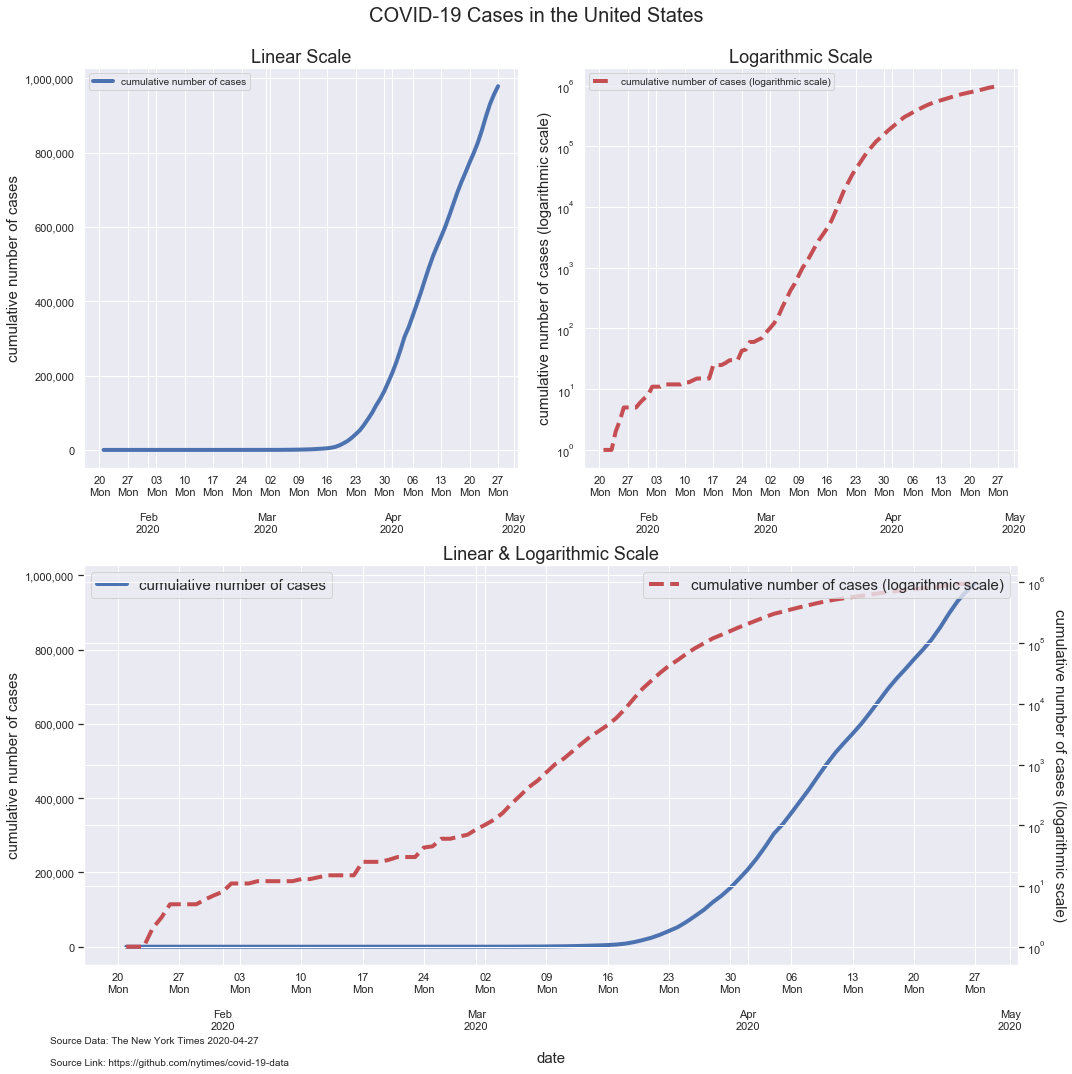

In [138]:
fig, [ax1, ax2, ax3, ax3_1] = plt.subplots(4, 1, sharex=True, figsize=(15,15))
fig.suptitle('COVID-19 Cases in the United States', y = .99, fontsize=20)
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

# Plot 1
ax3 = plt.subplot(212)
ax3.plot(g['cases'], linewidth=4)
ax3.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0), interval=1))
ax3.set_xlabel('Date', fontsize=15, labelpad = 20)
ax3.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax3_1 = ax3.twinx()  # instantiate a second axes that shares the same x-axis
ax3_1.plot(g['cases'], linewidth=4, color='r', linestyle='dashed')
ax3_1.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0), interval=1))
ax3_1.xaxis.grid(True, which="major")
ax3_1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax3_1.set_yscale('log')

ax3.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax3.xaxis.grid(True, which="major")
ax3.xaxis.set_major_locator(dates.MonthLocator())
ax3.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))

# Plot 2
ax1 = plt.subplot(221)
ax1.plot(g['cases'], linewidth=4)
ax1.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0), interval=1))
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax1.xaxis.grid(True, which="major")
ax1.xaxis.set_major_locator(dates.MonthLocator())
ax1.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))


# Plot 3
ax2 = plt.subplot(222)
ax2.plot(g['cases'], linewidth=4, color='r', linestyle='dashed')
ax2.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0), interval=1))

ax2.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax2.xaxis.grid(True, which="major")
ax2.xaxis.set_major_locator(dates.MonthLocator())
ax2.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))

# Formatting Grid
ax1.grid(True)
ax1.grid(which='minor')
ax2.grid(True)
ax2.grid(which='minor', axis='x')
ax3.grid(True)
ax3.grid(which='minor')
ax3_1.grid(True)
ax3_1.grid(which='minor', axis='x')
ax3_1.tick_params(axis='both', which='minor', length=0)

# Setting Labels
ax1.set_ylabel('cumulative number of cases', fontsize=15)
ax2.set_ylabel('cumulative number of cases (logarithmic scale)', fontsize=15)
ax3.set_ylabel('cumulative number of cases', fontsize=15)
ax3.set_xlabel('date', fontsize=15, labelpad = 20)
ax3_1.set_ylabel('cumulative number of cases (logarithmic scale)', fontsize=15, rotation = 270, labelpad = 20)
ax2.get_yaxis().set_visible(True)
ax2.set_yscale('log')
ax2.get_yaxis().set_visible(True)
ax3_1.get_yaxis().set_visible(True)
ax3_1.set_yscale('log')
ax3_1.get_yaxis().set_visible(True)

# Setting Titles
ax1.set_title('\n\nLinear Scale', fontsize=18)
ax2.set_title('Logarithmic Scale', fontsize=18)
ax3.set_title('Linear & Logarithmic Scale', fontsize=18)

# Setting Legends
ax1.legend(['cumulative number of cases'], loc=2, fontsize=10)
ax2.legend(['cumulative number of cases (logarithmic scale)'], loc=2, fontsize=10)
ax3.legend(['cumulative number of cases'], loc=2, fontsize=15)
ax3_1.legend(['cumulative number of cases (logarithmic scale)'], loc=1, fontsize=15)

plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/counties-3-subplots')

# Country Trajectory Plot

In [139]:
g['daily_cases'] = g['cases'].diff()

In [140]:
g.head(20)

date  cases  daily_cases
date                                     
2020-01-21 2020-01-21      1          NaN
2020-01-22 2020-01-22      1          0.0
2020-01-23 2020-01-23      1          0.0
2020-01-24 2020-01-24      2          1.0
2020-01-25 2020-01-25      3          1.0
2020-01-26 2020-01-26      5          2.0
2020-01-27 2020-01-27      5          0.0
2020-01-28 2020-01-28      5          0.0
2020-01-29 2020-01-29      5          0.0
2020-01-30 2020-01-30      6          1.0
2020-01-31 2020-01-31      7          1.0
2020-02-01 2020-02-01      8          1.0
2020-02-02 2020-02-02     11          3.0
2020-02-03 2020-02-03     11          0.0
2020-02-04 2020-02-04     11          0.0
2020-02-05 2020-02-05     12          1.0
2020-02-06 2020-02-06     12          0.0
2020-02-07 2020-02-07     12          0.0
2020-02-08 2020-02-08     12          0.0
2020-02-09 2020-02-09     12          0.0

In [141]:
g['daily_cases'].loc[g.daily_cases < 0] = g.cases
g['daily_cases'].loc[g.daily_cases.isnull()] = g.cases

In [142]:
g[:50]

date  cases  daily_cases
date                                     
2020-01-21 2020-01-21      1          1.0
2020-01-22 2020-01-22      1          0.0
2020-01-23 2020-01-23      1          0.0
2020-01-24 2020-01-24      2          1.0
2020-01-25 2020-01-25      3          1.0
2020-01-26 2020-01-26      5          2.0
2020-01-27 2020-01-27      5          0.0
2020-01-28 2020-01-28      5          0.0
2020-01-29 2020-01-29      5          0.0
2020-01-30 2020-01-30      6          1.0
2020-01-31 2020-01-31      7          1.0
2020-02-01 2020-02-01      8          1.0
2020-02-02 2020-02-02     11          3.0
2020-02-03 2020-02-03     11          0.0
2020-02-04 2020-02-04     11          0.0
2020-02-05 2020-02-05     12          1.0
2020-02-06 2020-02-06     12          0.0
2020-02-07 2020-02-07     12          0.0
2020-02-08 2020-02-08     12          0.0
2020-02-09 2020-02-09     12          0.0
2020-02-10 2020-02-10     13          1.0
2020-02-11 2020-02-11     13          0.0
2020-02-12 2020-02-12     14          1.0
2020-02-13 2020-02-13     15          1.0
2020-02-14 2020-02-14     15          0.0
2020-02-15 2020-02-15     15          0.0
2020-02-16 2020-02-16     15          0.0
2020-02-17 2020-02-17     25         10.0
2020-02-18 2020-02-18     25          0.0
2020-02-19 2020-02-19     25          0.0
2020-02-20 2020-02-20     27          2.0
2020-02-21 2020-02-21     30          3.0
2020-02-22 2020-02-22     30          0.0
2020-02-23 2020-02-23     30          0.0
2020-02-24 2020-02-24     43         13.0
2020-02-25 2020-02-25     45          2.0
2020-02-26 2020-02-26     60         15.0
2020-02-27 2020-02-27     60          0.0
2020-02-28 2020-02-28     65          5.0
2020-02-29 2020-02-29     70          5.0
2020-03-01 2020-03-01     86         16.0
2020-03-02 2020-03-02    102         16.0
2020-03-03 2020-03-03    123         21.0
2020-03-04 2020-03-04    159         36.0
2020-03-05 2020-03-05    226         67.0
2020-03-06 2020-03-06    308         82.0
2020-03-07 2020-03-07    425        117.0
2020-03-08 2020-03-08    544        119.0
2020-03-09 2020-03-09    745        201.0
2020-03-10 2020-03-10   1013        268.0

In [143]:
g_weekly = g.set_index('date').resample('W').agg({'cases': np.max, 'daily_cases': np.mean})

In [144]:
g_weekly

cases   daily_cases
date                            
2020-01-26       5      0.833333
2020-02-02      11      0.857143
2020-02-09      12      0.142857
2020-02-16      15      0.428571
2020-02-23      30      2.142857
2020-03-01      86      8.000000
2020-03-08     544     65.428571
2020-03-15    3570    432.285714
2020-03-22   32503   4133.285714
2020-03-29  137191  14955.428571
2020-04-05  329963  27538.857143
2020-04-12  548541  31225.428571
2020-04-19  747262  28388.714286
2020-04-26  957125  29980.428571
2020-05-03  979266  22141.000000

In [145]:
g_weekly.reset_index(inplace=True)
g_weekly.rename(columns={'cases_diff': 'cases_daily_week_avg'}, inplace=True)

In [146]:
g_weekly

date   cases   daily_cases
0  2020-01-26       5      0.833333
1  2020-02-02      11      0.857143
2  2020-02-09      12      0.142857
3  2020-02-16      15      0.428571
4  2020-02-23      30      2.142857
5  2020-03-01      86      8.000000
6  2020-03-08     544     65.428571
7  2020-03-15    3570    432.285714
8  2020-03-22   32503   4133.285714
9  2020-03-29  137191  14955.428571
10 2020-04-05  329963  27538.857143
11 2020-04-12  548541  31225.428571
12 2020-04-19  747262  28388.714286
13 2020-04-26  957125  29980.428571
14 2020-05-03  979266  22141.000000

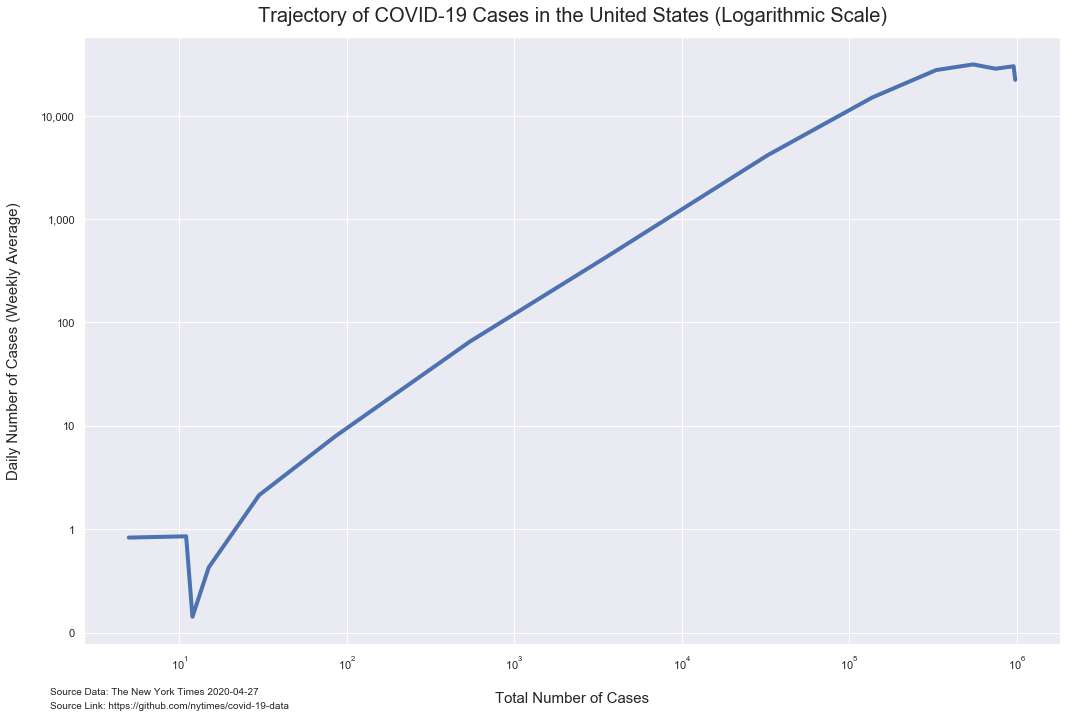

In [147]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="cases", y="daily_cases", data=g_weekly, linewidth=4)
ax1.set_yscale('log')
ax1.set_xscale('log')

ax1.xaxis.grid(True, which="major")
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax1.xaxis.labelpad = 20
ax1.yaxis.labelpad = 20

ax1.set_xlabel('Total Number of Cases', fontsize=15)
ax1.set_ylabel('Daily Number of Cases (Weekly Average)', fontsize=15)
plt.title('Trajectory of COVID-19 Cases in the United States (Logarithmic Scale)', 
          pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/usa-counties-trajectory-weekly-plot')

# Bar Chart

In [148]:
covid_19_counties_data

date      county       state     fips  cases  deaths  \
0     2020-01-21   Snohomish  Washington  53061.0      1       0   
1     2020-01-22   Snohomish  Washington  53061.0      1       0   
2     2020-01-23   Snohomish  Washington  53061.0      1       0   
3     2020-01-24        Cook    Illinois  17031.0      1       0   
4     2020-01-24   Snohomish  Washington  53061.0      1       0   
...          ...         ...         ...      ...    ...     ...   
95415 2020-04-27    Sublette     Wyoming  56035.0      1       0   
95416 2020-04-27  Sweetwater     Wyoming  56037.0     10       0   
95417 2020-04-27       Teton     Wyoming  56039.0     64       1   
95418 2020-04-27       Uinta     Wyoming  56041.0      6       0   
95419 2020-04-27    Washakie     Wyoming  56043.0      4       0   

                 county_name  
0      Snohomish, Washington  
1      Snohomish, Washington  
2      Snohomish, Washington  
3             Cook, Illinois  
4      Snohomish, Washington  
...                      ...  
95415      Sublette, Wyoming  
95416    Sweetwater, Wyoming  
95417         Teton, Wyoming  
95418         Uinta, Wyoming  
95419      Washakie, Wyoming  

[94367 rows x 7 columns]

In [149]:
# dropping ALL duplicate values 
county_current_cases = covid_19_counties_data.sort_values(by = 'date', 
                    ascending=False).drop_duplicates(
                    subset ="county_name", keep = 'first')

In [150]:
county_current_cases.head()

date    county     state     fips  cases  deaths  \
95419 2020-04-27  Washakie   Wyoming  56043.0      4       0   
93530 2020-04-27   Fayette  Kentucky  21067.0    239       9   
93538 2020-04-27    Graves  Kentucky  21083.0    119      11   
93537 2020-04-27     Grant  Kentucky  21081.0     18       3   
93536 2020-04-27   Garrard  Kentucky  21079.0      2       0   

             county_name  
95419  Washakie, Wyoming  
93530  Fayette, Kentucky  
93538   Graves, Kentucky  
93537    Grant, Kentucky  
93536  Garrard, Kentucky

In [151]:
county_current_cases.county_name.value_counts()

Obion, Tennessee            1
Hidalgo, Texas              1
Hughes, South Dakota        1
Taylor, Florida             1
La Crosse, Wisconsin        1
                           ..
Grand Traverse, Michigan    1
Lawrence, Tennessee         1
Bexar, Texas                1
Adair, Missouri             1
Wagoner, Oklahoma           1
Name: county_name, Length: 2821, dtype: int64

In [152]:
county_current_cases.loc[county_current_cases.county == 'New York City']

date         county     state  fips   cases  deaths  \
94264 2020-04-27  New York City  New York   NaN  160499   11857   

                   county_name  
94264  New York City, New York

In [153]:
bar = county_current_cases.sort_values(by = 'cases', 
                    ascending=False)
bar = bar[:20]

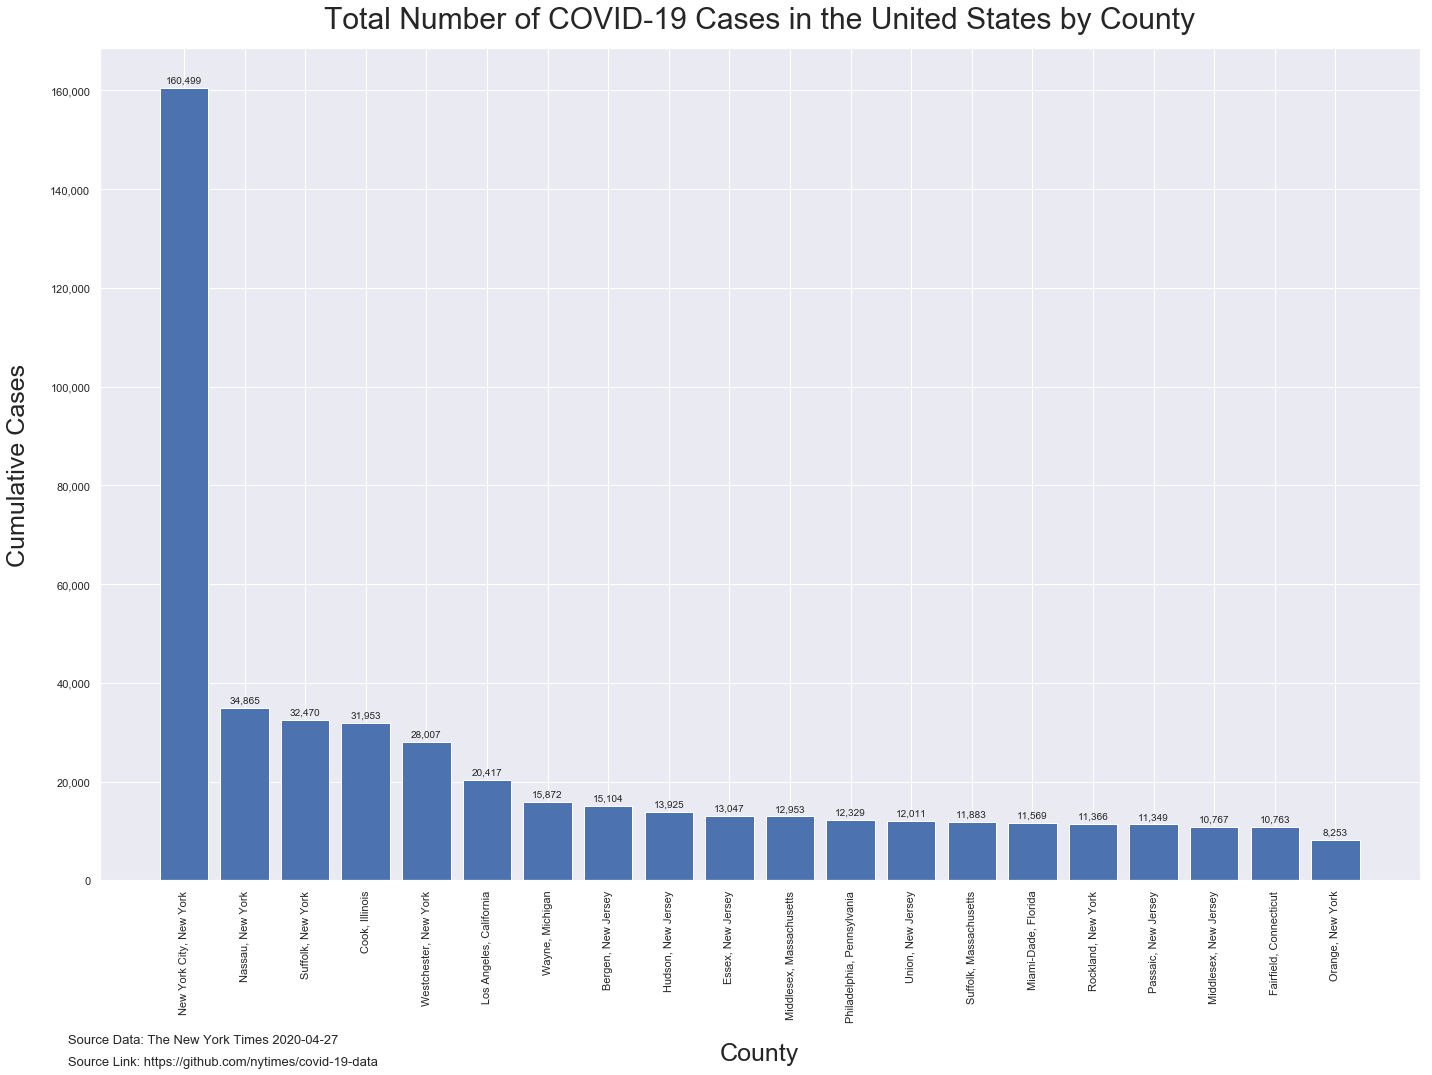

In [154]:
bar = bar.sort_values(by = 'cases', 
                    ascending=False)

bar.set_index('county_name', drop=False, inplace=True)

plt.subplots(figsize=(20,15))
ax = plt.subplot()

label = ax.bar(bar.index, bar.cases)
plt.xlabel("County", labelpad=14, fontsize=25)
plt.xticks(rotation=90)
plt.ylabel("Cumulative Cases", labelpad=14, fontsize=25)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.xaxis.labelpad = 20
ax.yaxis.labelpad = 20

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:,}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(label)

txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=13)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=13)

plt.title("Total Number of COVID-19 Cases in the United States by County", pad=20, fontsize=30)
plt.tight_layout()
plt.savefig('figures/counties-bar')

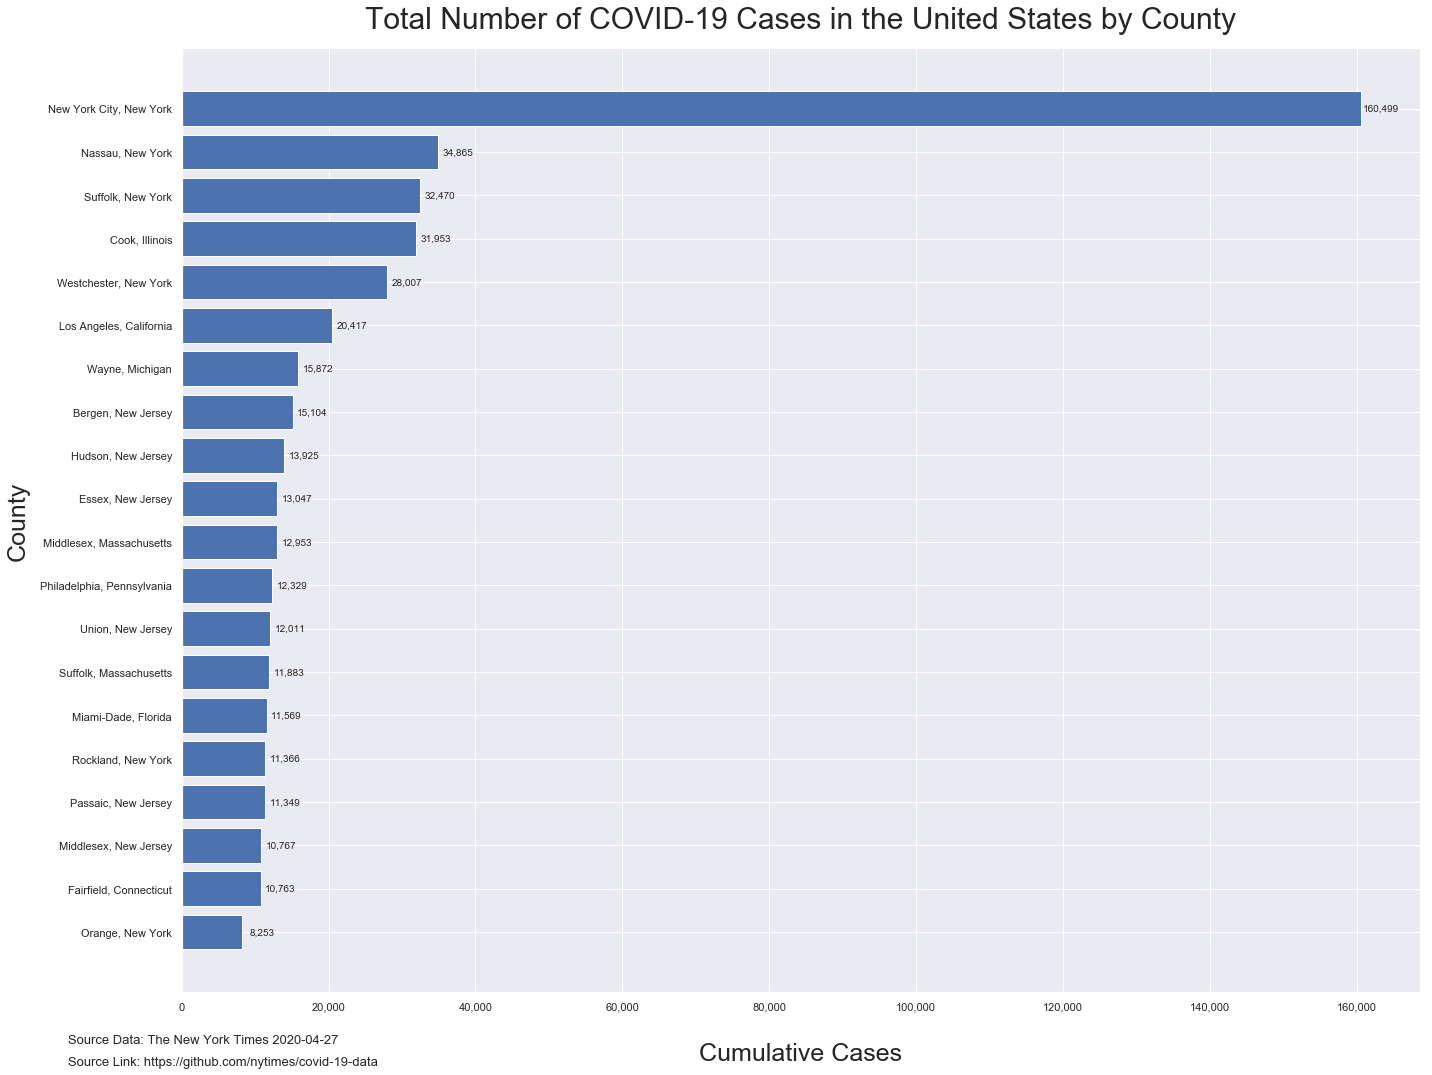

In [155]:
bar = bar.sort_values(by = 'cases', 
                    ascending=True)

bar.set_index('county_name', drop=False, inplace=True)

plt.subplots(figsize=(20,15))
ax = plt.subplot()

label_1 = ax.barh(bar.index, bar.cases)
plt.xlabel("Cumulative Cases", labelpad=14, fontsize=25)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.ylabel("County", labelpad=14, fontsize=25)
ax.xaxis.labelpad = 30
ax.yaxis.labelpad = 10

def autolabel_1(rects):
    for rect in rects:
        width = rect.get_width()
        yloc = rect.get_y() + rect.get_height() / 2
        ax.annotate('{:,}'.format(width), 
                    xy=(width, yloc), 
                    xytext=(20, 0),
                    textcoords="offset points",
                    ha='center', va='center')
                
autolabel_1(label_1)

txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=13)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=13)

plt.title("Total Number of COVID-19 Cases in the United States by County", pad=20, fontsize=30)
plt.tight_layout()
plt.savefig('figures/counties-barh')

In [156]:
covid_19_counties_data.to_csv('data/us-counties-raw-data.csv', index=False)
g.to_csv('data/us-counties-grouped-day.csv')
bar.to_csv('data/us-counties-grouped-bar.csv')